# Average K-Means
We investigate a k-means clustering variant where we upweight the within-class sum of squares for the minority class, and downweight the WCSS for the majority. In effect we switch WCSS for within-class mean-square-residual, hence the name "average k-means".

The usual k-means procedure (Lloyd's algorithm) cannot be modified to optimize the average k-means objective. Possible ways to solve it:
* Sequentially test splits along PC1, PC2, … PC_d
    * Under what conditions will the optimal split be somewhere on a PC?
* A graph algorithm (Bradley, Bennett, Demiriz; or https://en.wikipedia.org/wiki/Kernighan%E2%80%93Lin_algorithm)
* A conic programming algorithm (Rujeerapaiboon et al)
* A genetic algorithm (Krishna & Murty, 


In the paper, may be worth discussing that the k-means objective had a really specific purpose, regarding telephony, so it's important to look for generalizations. As I understand so far, in digital audio, you sample the amplitude of a signal many times per second. If you use more bits to represent each amplitude sample, you get higher fidelity. Since you're using bits, you have some rounding. So what you can do is have the bits correspond to bins of whatever size you want. Really, each possible value is representing a centroid of a cluster to which the sample will be assigned. Lloyd wanted to find, for a given number of possible centroids, the best values of those centroids for maximizing the fidelity. I.e. if you can only use 8 numbers, which ones should you use? (think about square loss as well)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.linalg import sqrtm
import seaborn as sns

In [86]:
import matplotlib as mpl

In [2]:
import scipy.stats

In [3]:
import sigclust

In [4]:
from importlib import reload
from collections import Counter

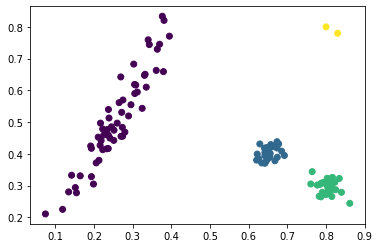

In [5]:
toy = pd.read_csv('examples/sigclust_toy_data.csv', header=None)
toy = toy.T
toy.columns = ['label', 'x1', 'x2']
plt.scatter(toy['x1'], toy['x2'], c=toy['label'])

## Definitions of CI and Avg CI

$$\begin{aligned}
CI &= \frac{\sum_{x \in C_1} ||x- \bar{x}_1||^2 + \sum_{x \in C_2} ||x- \bar{x}_2||^2}{\sum ||x-\bar{x}||^2} \\
Avg CI &= \frac{\frac{1}{|C_1|}\sum_{x \in C_1} ||x- \bar{x}_1||^2 + \frac{1}{|C_2|}\sum_{x \in C_2} ||x- \bar{x}_2||^2}{\frac{1}{|C_1|}\sum_{x \in C_1} ||x- \bar{x}||^2 + \frac{1}{|C_2|}\sum_{x \in C_2} ||x- \bar{x}||^2}
\end{aligned}$$

Observe that both must live on $[0,1]$.

### Functions for computing these criteria from given splits:

In [6]:
def compute_average_cluster_index_numerator(class_1, class_2):
    """Compute the average cluster index for the two given classes"""
    n1 = class_1.shape[0]
    n2 = class_2.shape[0]
    class_1_MSE = sigclust.compute_sum_of_square_distances_to_mean(class_1) / n1
    class_2_MSE = sigclust.compute_sum_of_square_distances_to_mean(class_2) / n2
    return class_1_MSE + class_2_MSE

In [7]:
def compute_average_cluster_index(class_1, class_2):
    n1 = class_1.shape[0]
    n2 = class_2.shape[0]
    overall_mean = np.concatenate([class_1, class_2]).mean()
    denominator = (sigclust.compute_sum_of_square_distances_to_point(class_1, overall_mean) / n1 + 
                   sigclust.compute_sum_of_square_distances_to_point(class_2, overall_mean) / n2 )
    numerator = compute_average_cluster_index_numerator(class_1, class_2)
    return numerator/denominator

In [8]:
def compute_cluster_index_numerator(class_1, class_2):
    class_1_SSE = sigclust.compute_sum_of_square_distances_to_mean(class_1)
    class_2_SSE = sigclust.compute_sum_of_square_distances_to_mean(class_2)
    return class_1_SSE + class_2_SSE

def compute_cluster_index(class_1, class_2):
    numerator = compute_cluster_index_numerator(class_1, class_2)
    denominator = sigclust.compute_sum_of_square_distances_to_mean(np.concatenate([class_1, class_2]))
    return numerator/denominator


### Function to plot all criteria as a function of where you split on PC1
Note: interesting research idea: under what regularity conditions can we find the optimal split somewhere on a PC direction?

In [9]:
def plot_criteria(data):
    scores = PCA().fit_transform(data)
    scores_df = pd.DataFrame(scores, columns=['PC1', 'PC2'], index=data.index)
    
    pc1 = scores_df['PC1']
    
    def split_data_by_score(score):
        class_1 = data[pc1 <= score]
        class_2 = data[pc1 > score]
        return (class_1, class_2)
    
    def compute_avg_ci_numerator_by_score(score):
        class_1, class_2 = split_data_by_score(score)
        return compute_average_cluster_index_numerator(class_1, class_2)
    
    def compute_avg_ci_by_score(score):
        class_1, class_2 = split_data_by_score(score)
        return compute_average_cluster_index(class_1, class_2)
    
    def compute_ci_by_score(score):
        class_1, class_2 = split_data_by_score(score)
        ci = compute_cluster_index(class_1, class_2)
        return ci
    
    
    avg_ci_numerators = pc1.map(compute_avg_ci_numerator_by_score)
    avg_cis = pc1.map(compute_avg_ci_by_score)
    cis = pc1.map(compute_ci_by_score)
    
    criteria_df = pd.DataFrame({'PC1': pc1, 'ci': cis, 'avg_ci': avg_cis, 'avg_ci_numerator': avg_ci_numerators}).sort_values('PC1')
    criteria_df2 = criteria_df.set_index('PC1')

    fig, axs = plt.subplots(4, 1, figsize=(5,5), sharex=True)
    axs[-1].scatter(scores_df['PC1'], scores_df['PC2'])
    axs[-1].axhline(0, color='black')
    axs[-1].set_xlabel('PC1 score')
    axs[-1].set_ylabel('PC2')
    #axs[-1].axis('square')
    for x in scores_df['PC1']:
        for ax in axs:
            ax.axvline(x, alpha=0.1, color='gray')
            
    axs[0].plot(criteria_df['PC1'], criteria_df['ci'])
    axs[0].set_title("Cluster Index")
    
    axs[1].plot(criteria_df['PC1'], criteria_df['avg_ci'])
    axs[1].set_title("Avg Cluster Index")
    
    axs[2].plot(criteria_df['PC1'], criteria_df['avg_ci_numerator'])
    axs[2].set_title("Avg Cluster Index Numerator")
    
    fig.tight_layout()

## Long gaussian plus two outliers

/Users/thomaskeefe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/thomaskeefe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


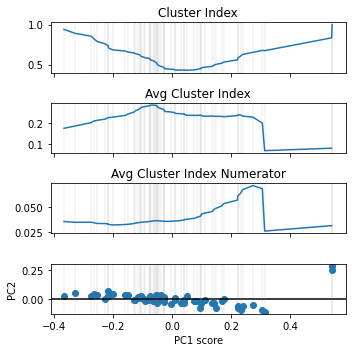

In [10]:
stretched_gaussian_plus_outliers = toy[toy['label'].isin([1,4])]
plot_criteria(stretched_gaussian_plus_outliers[['x1','x2']])

The Avg CI and Avg CI Numerator give the desired split.

## Long gaussian alone

/Users/thomaskeefe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/thomaskeefe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


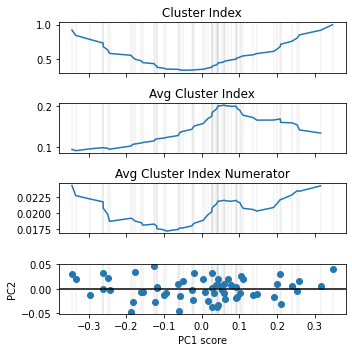

In [11]:
long_gaussian = toy[toy['label']==1][['x1','x2']]
plot_criteria(long_gaussian)

It doesn't seem like good news for the Avg CI that the minima are at the end points. The Avg CI Numerator is more wobbly, which will be sensitive to noise.

## Gaussian with a lot more points

In [12]:
large_gaussian_sample = np.random.multivariate_normal((0,0), np.cov(long_gaussian.T), 5000)

/Users/thomaskeefe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/thomaskeefe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


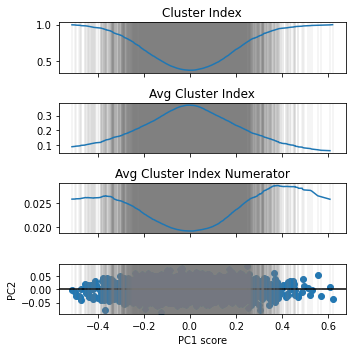

In [13]:
plot_criteria(pd.DataFrame(large_gaussian_sample))

## Both spherical clusters

/Users/thomaskeefe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/thomaskeefe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


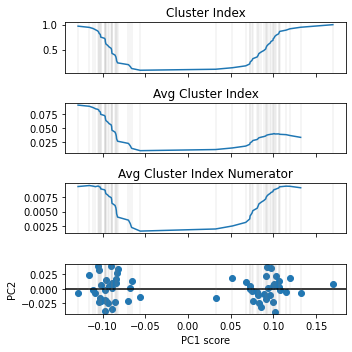

In [14]:
sphericals = toy[toy['label'].isin([2,3])]
plot_criteria(sphericals[['x1','x2']])

## Long gaussian plus both sphericals

/Users/thomaskeefe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/thomaskeefe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


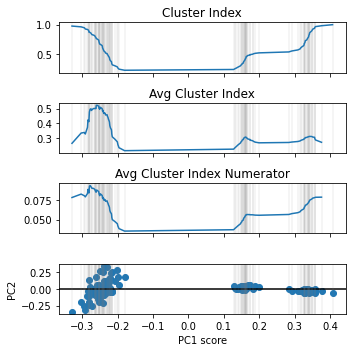

In [15]:
data = toy[toy['label'].isin([1,2,3])][['x1', 'x2']]
plot_criteria(data)

# Flattening the CI curve

$$\begin{aligned}
CI &= \frac{\sum_{x \in C_1} ||x- \bar{x}_1||^2 + \sum_{x \in C_2} ||x- \bar{x}_2||^2}{\sum ||x-\bar{x}||^2} \\ \\
Avg CI &= \frac{\frac{1}{|C_1|}\sum_{x \in C_1} ||x- \bar{x}_1||^2 + \frac{1}{|C_2|}\sum_{x \in C_2} ||x- \bar{x}_2||^2}{\frac{1}{|C_1|}\sum_{x \in C_1} ||x- \bar{x}||^2 + \frac{1}{|C_2|}\sum_{x \in C_2} ||x- \bar{x}||^2} \\ \\
Avg CI_p &= \frac{\frac{1}{|C_1|^p}\sum_{x \in C_1} ||x- \bar{x}_1||^2 + \frac{1}{|C_2|^p}\sum_{x \in C_2} ||x- \bar{x}_2||^2}{\frac{1}{|C_1|^p}\sum_{x \in C_1} ||x- \bar{x}||^2 + \frac{1}{|C_2|^p}\sum_{x \in C_2} ||x- \bar{x}||^2} 
\end{aligned}$$

When $p = 0$ the new $Avg CI_p$ is CI, and when $p = 1$ it is $Avg CI$. Furthermore, when the classes are balanced, the exponent p doesn't do anything.

In [17]:
def avg_cluster_index_p_exp(class_1, class_2, p):
    class_1_SSE = sigclust.compute_sum_of_square_distances_to_mean(class_1)
    class_2_SSE = sigclust.compute_sum_of_square_distances_to_mean(class_2)
    n1 = class_1.shape[0]
    n2 = class_2.shape[0]
    overall_mean = np.concatenate([class_1, class_2]).mean()
    
    numerator = (1/n1)**p * class_1_SSE + (1/n2)**p * class_2_SSE
    denominator = (sigclust.compute_sum_of_square_distances_to_point(class_1, overall_mean) / n1**p + 
                   sigclust.compute_sum_of_square_distances_to_point(class_2, overall_mean) / n2**p )
    return numerator/denominator
    

In [18]:
Z = scipy.stats.norm.ppf(np.linspace(0.001, .999, 5000))

In [19]:
results = pd.DataFrame({'Z': Z})

for p in np.linspace(0,1,40):
    cis = []
    for i in range(len(Z)-1):
        class_1 = Z[:i+1, np.newaxis]
        class_2 = Z[i+1:, np.newaxis]
        ci = avg_cluster_index_p_exp(class_1, class_2, p)
        cis.append(ci)
    
    cis.append(cis[-1])
    results[p] = cis

In [20]:
resultsZ = results.set_index('Z')

In [21]:
resultsZ.head()

,0.000000,0.025641,0.051282,0.076923,0.102564,0.128205,0.153846,0.179487,0.205128,0.230769,...,0.769231,0.794872,0.820513,0.846154,0.871795,0.897436,0.923077,0.948718,0.974359,1.000000
Z,,,,,,,,,,,,,,,,,,,,,
-3.090232,0.998052,0.997578,0.996989,0.996257,0.995348,0.994219,0.992819,0.991082,0.988929,0.986265,...,0.422604,0.370406,0.321069,0.275430,0.234041,0.197180,0.164874,0.136959,0.113129,0.092999
-3.035763,0.996173,0.995327,0.994295,0.993036,0.991503,0.989635,0.987362,0.984599,0.981242,0.977170,...,0.387946,0.341519,0.297945,0.257755,0.221280,0.188656,0.159856,0.134725,0.113015,0.094424
-2.989039,0.994350,0.993175,0.991757,0.990048,0.987989,0.985510,0.982529,0.978946,0.974648,0.969499,...,0.369387,0.326296,0.285955,0.248764,0.214956,0.184618,0.157705,0.134075,0.113513,0.095760
-2.948051,0.992576,0.991102,0.989337,0.987226,0.984704,0.981693,0.978102,0.973826,0.968740,0.962704,...,0.357159,0.316387,0.278259,0.243097,0.211084,0.182277,0.156627,0.134002,0.114209,0.097019
-2.911488,0.990846,0.989094,0.987010,0.984534,0.981595,0.978109,0.973979,0.969096,0.963329,0.956535,...,0.348271,0.309260,0.272796,0.239149,0.208470,0.180799,0.156086,0.134205,0.114983,0.098212


## $Avg CI_p$ for different values of $p$ on a large $N(0,1)$ population:

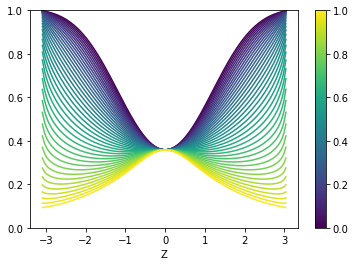

In [91]:
fig, ax = plt.subplots()
im = resultsZ.iloc[:-1, :].plot(kind='line', colormap='viridis', legend=False, ax=ax)
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap='viridis'))
ax.set_ylim(0, 1);

Zoom in on some values of $p$ where the curve is flattest:

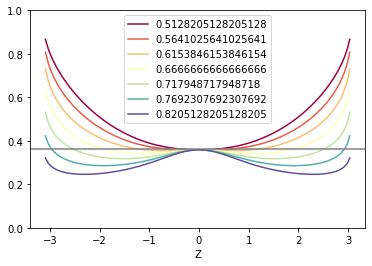

In [23]:
fig, ax = plt.subplots()
resultsZ.iloc[:-1, 20:33:2].plot(kind='line', ax=ax, colormap='Spectral')
ax.set_ylim(0,1)
ax.axhline(0.36338, color='gray')

### Try to make the second derivative at 0 equal to 0:

In [24]:
first_derivative = (resultsZ.shift(-1) - resultsZ) * 5000/.998

In [25]:
second_derivative = (first_derivative.shift(-1) - first_derivative) * 5000/.998

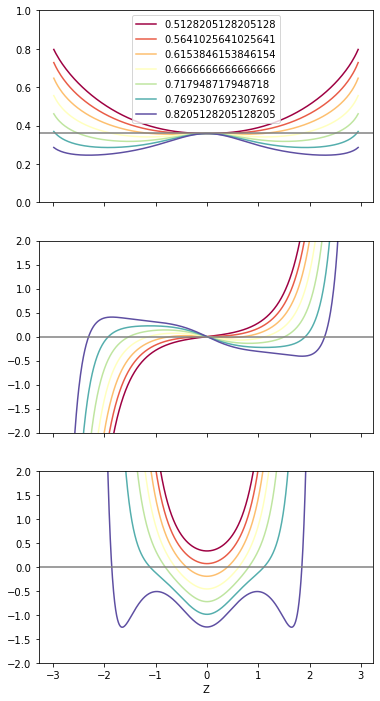

In [26]:
fig, axs = plt.subplots(3, figsize=(6,12), sharex=True)
resultsZ.iloc[2:-3, 20:33:2].plot(kind='line', ax=axs[0], colormap='Spectral')
axs[0].set_ylim(0,1)
axs[0].axhline(0.36338, color='gray')

first_derivative.iloc[2:-3, 20:33:2].plot(kind='line', ax=axs[1], colormap='Spectral', legend=False)

axs[1].set_ylim(-2, 2)
axs[1].axhline(0, color='gray')

second_derivative.iloc[2:-3, 20:33:2].plot(kind='line', ax=axs[2], colormap='Spectral', legend=False)

axs[2].set_ylim(-2, 2)
axs[2].axhline(0, color='gray')

#### Plot $f''(0)$ as a function of $p$

Text(0.5, 1.0, "f''(0) as function of p")

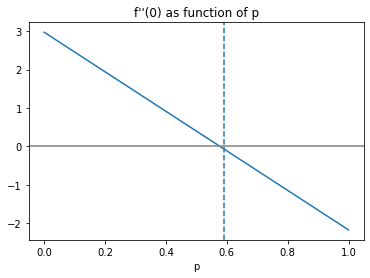

In [27]:
second_derivative.loc[0.00025021154672772247].plot(kind='line')
optimal_p = second_derivative.loc[0.00025021154672772247].abs().idxmin()
plt.xlabel('p')
plt.axhline(0, color='gray')
plt.axvline(optimal_p, linestyle='--')
plt.title("f''(0) as function of p")

In [28]:
optimal_p

0.5897435897435898

### Try to make the first derivative zero

In [29]:
first_derivative

,0.000000,0.025641,0.051282,0.076923,0.102564,0.128205,0.153846,0.179487,0.205128,0.230769,...,0.769231,0.794872,0.820513,0.846154,0.871795,0.897436,0.923077,0.948718,0.974359,1.000000
Z,,,,,,,,,,,,,,,,,,,,,
-3.090232,-9.418584,-11.281604,-13.499797,-16.136365,-19.264114,-22.966256,-27.336956,-32.481462,-38.515519,-45.563731,...,-173.635774,-144.721534,-115.854796,-88.549828,-63.935993,-42.705785,-25.141231,-11.191546,-0.572167,7.138571
-3.035763,-9.132407,-10.780701,-12.711909,-14.969818,-17.603314,-20.666319,-24.217398,-28.318868,-33.035234,-38.430679,...,-92.982522,-76.268119,-60.067354,-45.048250,-31.680440,-20.228653,-10.774454,-3.254848,2.493334,6.691592
-2.989039,-8.884748,-10.386931,-12.127697,-14.140017,-16.459740,-19.125190,-22.176437,-25.654106,-29.597607,-34.042585,...,-61.260586,-49.644414,-38.559085,-28.391182,-19.402069,-11.729378,-5.402808,-0.367990,3.487333,6.309016
-2.948051,-8.666582,-10.057302,-11.655182,-13.486068,-15.577365,-17.957475,-20.654937,-23.697165,-27.108683,-30.908742,...,-44.530121,-35.706973,-27.371365,-19.778111,-13.094285,-7.402555,-2.713062,1.020108,3.881334,5.977298
-2.911488,-8.471723,-9.772361,-11.256194,-12.943962,-14.857099,-17.017106,-19.444648,-22.158298,-25.172868,-28.497242,...,-34.323443,-27.254742,-20.624362,-14.613923,-9.339462,-4.855064,-1.162118,1.778504,4.033694,5.686445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.911488,8.884748,10.386931,12.127697,14.140017,16.459740,19.125190,22.176437,25.654106,29.597607,34.042585,...,61.260586,49.644414,38.559085,28.391182,19.402069,11.729378,5.402808,0.367990,-3.487333,-6.309016
2.948051,9.132407,10.780701,12.711909,14.969818,17.603314,20.666319,24.217398,28.318868,33.035234,38.430679,...,92.982522,76.268119,60.067354,45.048250,31.680440,20.228653,10.774454,3.254848,-2.493334,-6.691592
2.989039,9.418584,11.281604,13.499797,16.136365,19.264114,22.966256,27.336956,32.481462,38.515519,45.563731,...,173.635774,144.721534,115.854796,88.549828,63.935993,42.705785,25.141231,11.191546,0.572167,-7.138571


In [30]:
from scipy.linalg import norm

In [31]:
L1_norms = first_derivative.iloc[2:-2].apply(lambda f: norm(f, 1))

In [32]:
L2_norms = first_derivative.iloc[2:-2].apply(lambda f: norm(f, 2))
Linf_norms = first_derivative.iloc[2:-2].apply(lambda f: norm(f, np.inf))

[Text(0.0, 0, '0'), Text(0.9743589743589743, 0, '0.97'), Text(1.0, 0, '1')]

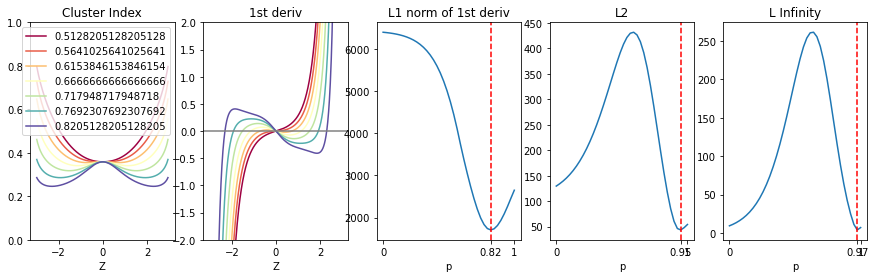

In [33]:
fig, axs = plt.subplots(1,5, figsize=(15,4))
resultsZ.iloc[2:-3, 20:33:2].plot(kind='line', ax=axs[0], colormap='Spectral')
axs[0].set_ylim(0,1)
axs[0].set_title("Cluster Index")

first_derivative.iloc[2:-3, 20:33:2].plot(kind='line', ax=axs[1], colormap='Spectral', legend=False)
axs[1].set_ylim(-2, 2)
axs[1].axhline(0, color='gray')
axs[1].set_title("1st deriv")

axs[2].plot(L1_norms.index, L1_norms)
axs[2].set_xlabel('p')
axs[2].set_title("L1 norm of 1st deriv")
axs[2].axvline(L1_norms.idxmin(), color='red', linestyle='--')
axs[2].set_xticks([0, L1_norms.idxmin(), 1])
axs[2].set_xticklabels(["0", f"{L1_norms.idxmin():.2f}", "1"])

axs[3].plot(L2_norms.index, L2_norms)
axs[3].set_xlabel('p')
axs[3].set_title("L2")
axs[3].axvline(L2_norms.idxmin(), color='red', linestyle='--')
axs[3].set_xticks([0, L2_norms.idxmin(), 1])
axs[3].set_xticklabels(["0", f"{L2_norms.idxmin():.2f}", "1"])

axs[4].plot(Linf_norms.index, Linf_norms)
axs[4].set_xlabel('p')
axs[4].set_title("L Infinity")
axs[4].axvline(Linf_norms.idxmin(), color='red', linestyle='--')
axs[4].set_xticks([0, Linf_norms.idxmin(), 1])
axs[4].set_xticklabels(["0", f"{Linf_norms.idxmin():.2f}", "1"])



#### What about just looking at the numerator?

In [35]:
def avg_cluster_index_p_exp_num(class_1, class_2, p):
    class_1_SSE = sigclust.compute_sum_of_square_distances_to_mean(class_1)
    class_2_SSE = sigclust.compute_sum_of_square_distances_to_mean(class_2)
    n1 = class_1.shape[0]
    n2 = class_2.shape[0]
    overall_mean = np.concatenate([class_1, class_2]).mean()
    
    numerator = (1/n1)**p * class_1_SSE + (1/n2)**p * class_2_SSE
    # denominator = (sigclust.compute_sum_of_square_distances_to_point(class_1, overall_mean) / n1**p + 
    #               sigclust.compute_sum_of_square_distances_to_point(class_2, overall_mean) / n2**p )
    return numerator

In [36]:
results2 = pd.DataFrame({'Z': Z})

for p in np.linspace(0,1,40):
    cis = []
    for i in range(len(Z)-1):
        class_1 = Z[:i+1, np.newaxis]
        class_2 = Z[i+1:, np.newaxis]
        ci = avg_cluster_index_p_exp_num(class_1, class_2, p)
        cis.append(ci)
    
    cis.append(cis[-1])
    results2[p] = cis

In [37]:
results2Z = results2.set_index('Z')

In [39]:
results2Z

,0.000000,0.025641,0.051282,0.076923,0.102564,0.128205,0.153846,0.179487,0.205128,0.230769,...,0.769231,0.794872,0.820513,0.846154,0.871795,0.897436,0.923077,0.948718,0.974359,1.000000
Z,,,,,,,,,,,,,,,,,,,,,
-3.090232,4894.820511,3934.536820,3162.645076,2542.185862,2043.450593,1642.559024,1320.315820,1061.291460,853.083442,685.722429,...,6.989435,5.618222,4.516019,3.630050,2.917893,2.345450,1.885311,1.515444,1.218139,0.979160
-3.035763,4885.600540,3927.146066,3156.720721,2537.437040,2039.644127,1639.507980,1317.870344,1059.331419,851.512530,684.463446,...,6.978211,5.609385,4.509091,3.624650,2.913715,2.342249,1.882890,1.513645,1.216836,0.978253
-2.989039,4876.660711,3919.980760,3150.977848,2532.834357,2035.955385,1636.551816,1315.501376,1057.433111,849.991468,683.244750,...,6.967844,5.601295,4.502820,3.619828,2.910048,2.339500,1.880870,1.512203,1.215850,0.977627
-2.948051,4867.963319,3913.010612,3145.392123,2528.358262,2032.368654,1633.677898,1313.198757,1055.588362,848.513672,682.061036,...,6.958150,5.593785,4.497048,3.615438,2.906754,2.337074,1.879129,1.511003,1.215074,0.977181
-2.911488,4859.479492,3906.212412,3139.944881,2523.993739,2028.871854,1630.876501,1310.954652,1053.790854,847.074044,680.908186,...,6.948999,5.586734,4.491665,3.611377,2.903739,2.334885,1.877590,1.509972,1.214439,0.976854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.911488,4867.963319,3913.010612,3145.392123,2528.358262,2032.368654,1633.677898,1313.198757,1055.588362,848.513672,682.061036,...,6.958150,5.593785,4.497048,3.615438,2.906754,2.337074,1.879129,1.511003,1.215074,0.977181
2.948051,4876.660711,3919.980760,3150.977848,2532.834357,2035.955385,1636.551816,1315.501376,1057.433111,849.991468,683.244750,...,6.967844,5.601295,4.502820,3.619828,2.910048,2.339500,1.880870,1.512203,1.215850,0.977627
2.989039,4885.600540,3927.146066,3156.720721,2537.437040,2039.644127,1639.507980,1317.870344,1059.331419,851.512530,684.463446,...,6.978211,5.609385,4.509091,3.624650,2.913715,2.342249,1.882890,1.513645,1.216836,0.978253


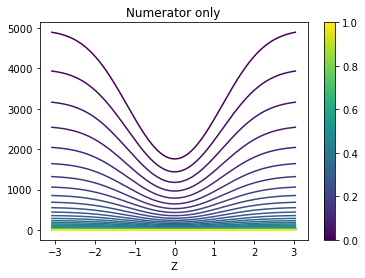

In [102]:
fig, ax = plt.subplots()
im = results2Z.iloc[:-1, :].plot(kind='line', colormap='viridis', legend=False, ax=ax)
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap='viridis'))
plt.title('Numerator only');
#ax.set_ylim((0, 2));

###  3rd idea: 
$$\begin{aligned}
Avg CI_p &= \frac{\frac{1}{|C_1|^p}\sum_{x \in C_1} ||x- \bar{x}_1||^2 + \frac{1}{|C_2|^p}\sum_{x \in C_2} ||x- \bar{x}_2||^2}{\frac{1}{(|C_1| + |C_2|)^p}\sum_{x } ||x- \bar{x}||^2} 
\end{aligned}$$


In [51]:
def avg_cluster_index_p_exp3(class_1, class_2, p):
    class_1_SSE = sigclust.compute_sum_of_square_distances_to_mean(class_1)
    class_2_SSE = sigclust.compute_sum_of_square_distances_to_mean(class_2)
    n1 = class_1.shape[0]
    n2 = class_2.shape[0]
    overall_mean = np.concatenate([class_1, class_2]).mean()
    
    numerator = (1/n1)**p * class_1_SSE + (1/n2)**p * class_2_SSE
    denominator = (sigclust.compute_sum_of_square_distances_to_point(class_1, overall_mean) + 
                   sigclust.compute_sum_of_square_distances_to_point(class_2, overall_mean)  ) / (n1+n2)**p
    return numerator/denominator

In [73]:
results3 = pd.DataFrame({'Z': Z})

for p in np.linspace(0,1.5,40):
    cis = []
    for i in range(len(Z)-1):
        class_1 = Z[:i+1, np.newaxis]
        class_2 = Z[i+1:, np.newaxis]
        ci = avg_cluster_index_p_exp3(class_1, class_2, p)
        cis.append(ci)
    
    cis.append(cis[-1])
    results3[p] = cis

In [74]:
results3Z = results3.set_index('Z')

In [75]:
results3Z

,0.000000,0.038462,0.076923,0.115385,0.153846,0.192308,0.230769,0.269231,0.307692,0.346154,...,1.153846,1.192308,1.230769,1.269231,1.307692,1.346154,1.384615,1.423077,1.461538,1.500000
Z,,,,,,,,,,,,,,,,,,,,,
-3.090232,0.998052,0.998060,0.998068,0.998075,0.998083,0.998091,0.998099,0.998106,0.998114,0.998122,...,0.998283,0.998291,0.998298,0.998306,0.998314,0.998321,0.998329,0.998337,0.998344,0.998352
-3.035763,0.996173,0.996188,0.996203,0.996219,0.996235,0.996250,0.996266,0.996282,0.996298,0.996315,...,0.999152,1.000052,1.001263,1.002893,1.005091,1.008055,1.012054,1.017452,1.024739,1.034580
-2.989039,0.994350,0.994373,0.994396,0.994420,0.994444,0.994468,0.994492,0.994517,0.994543,0.994569,...,1.000496,1.002321,1.004741,1.007953,1.012219,1.017884,1.025413,1.035421,1.048726,1.066416
-2.948051,0.992576,0.992608,0.992639,0.992671,0.992703,0.992736,0.992769,0.992804,0.992839,0.992876,...,1.002076,1.004815,1.008410,1.013129,1.019327,1.027472,1.038178,1.052252,1.070758,1.095094
-2.911488,0.990846,0.990886,0.990926,0.990966,0.991007,0.991048,0.991091,0.991135,0.991182,0.991230,...,1.003757,1.007377,1.012087,1.018219,1.026206,1.036611,1.050171,1.067846,1.090889,1.120932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.911488,0.992576,0.992608,0.992639,0.992671,0.992703,0.992736,0.992769,0.992804,0.992839,0.992876,...,1.002076,1.004815,1.008410,1.013129,1.019327,1.027472,1.038178,1.052252,1.070758,1.095094
2.948051,0.994350,0.994373,0.994396,0.994420,0.994444,0.994468,0.994492,0.994517,0.994543,0.994569,...,1.000496,1.002321,1.004741,1.007953,1.012219,1.017884,1.025413,1.035421,1.048726,1.066416
2.989039,0.996173,0.996188,0.996203,0.996219,0.996235,0.996250,0.996266,0.996282,0.996298,0.996315,...,0.999152,1.000052,1.001263,1.002893,1.005091,1.008055,1.012054,1.017452,1.024739,1.034580


New objective one more time
$$\begin{aligned}
Avg CI_p &= \frac{\frac{1}{|C_1|^p}\sum_{x \in C_1} ||x- \bar{x}_1||^2 + \frac{1}{|C_2|^p}\sum_{x \in C_2} ||x- \bar{x}_2||^2}{\frac{1}{(|C_1| + |C_2|)^p}\sum_{x } ||x- \bar{x}||^2} 
\end{aligned}$$

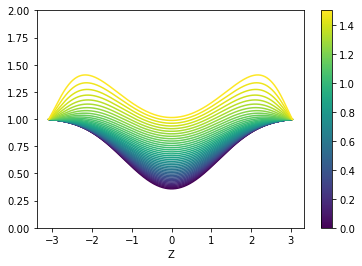

In [95]:
fig, ax = plt.subplots()
im = results3Z.iloc[:-1, :].plot(kind='line', colormap='viridis', legend=False, ax=ax)
ax.set_ylim((0, 2))
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1.5), cmap='viridis'))


# Old stuff
# Power analysis

In [33]:
import sigclust.sigclust

In [34]:
import sigclust.avg_2means

In [35]:
reload(sigclust.avg_2means)

<module 'sigclust.avg_2means' from '/Users/thomaskeefe/Documents/sigclust/sigclust/avg_2means.py'>

In [87]:
def simulate_balances(data, p, nsim=100):
    n, d = data.shape
    eigenvalues = sigclust.get_eigenvalues(data, covariance_method='sample_covariance')
    balances = []
    for i in range(nsim):
        clusterer = sigclust.Avg2Means()
        data = np.random.standard_normal((n, d)) * np.sqrt(eigenvalues)
        clusterer.fit(data, p)
        counts = Counter(clusterer.labels)
        balances.append(min(counts.values()))
    return np.array(balances)

In [37]:
def value_counts(arr):
    counts = Counter(arr)
    sorted_counts = sorted(counts.items(), key=lambda x: x[0])
    return "\n".join([f"{val}: {count}" for (val, count) in sorted_counts])

In [38]:
def plot_ellipse(data, ax=None, **kwargs):
    "Plot covariance ellipse of given data to axis"
    if isinstance(data, pd.DataFrame):
        data = data.values
    if ax is None:
        fig, ax = plt.subplots()
    
    mean = np.mean(data, axis=0)
    mean = mean.reshape(-1, 1)  # as column vector
    cov = np.cov(data.T)
    ncpts = 401
    
    # Equally spaced angles
    vangles = np.linspace(0, 2*np.pi, ncpts) 
    
    # Equally spaced points on unit circle
    mucirc = np.vstack([np.cos(vangles), np.sin(vangles)])

    muellips = np.tile(mean, ncpts) + 2 * np.diag((1,1)) @ sqrtm(cov) @ mucirc
    ax.plot(muellips[0,:], muellips[1,:], **kwargs) 

In [43]:
ps = [0.0, .2, .4, .45, .5, .55, .6, .8, 1.0]

In [75]:
# clusterers = [sigclust.Avg2Means() for p in ps]
# for p, c in zip(ps, clusterers):
#     c.fit(stretched_gaussian_plus_outliers[['x1','x2']].values, p)

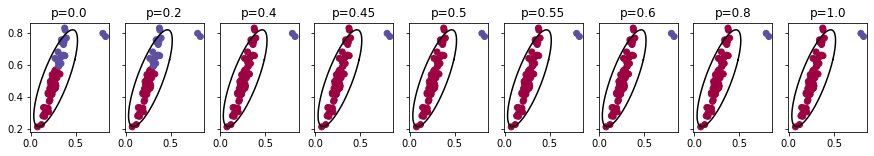

In [76]:
fig, axs = plt.subplots(1, 9, figsize=(15,2), sharey=True)
for i, c in enumerate(clusterers):
    ax = axs[i]
    ax.set_title(f"p={ps[i]}")
    labels = c.labels
    ax.scatter(stretched_gaussian_plus_outliers['x1'], stretched_gaussian_plus_outliers['x2'], c=labels, cmap='Spectral')
    plot_ellipse(stretched_gaussian_plus_outliers[['x1','x2']], ax=ax, color='black')

In [137]:
loosedash = (0, (4, 4))  # used for plotting dashed lines

class Example:
    def __init__(self, name, nsim=300):
        self.name = name
        self.nsim = nsim
        self.sigclusts = []
        self.clusterers = []
        self.balances = []
        self.true_cis = []
        self.true_zs = []
        
    def fit(self, data, labels=None):
        self.data = data
        self.labels = labels 
        
        for p in ps:
            c = sigclust.Avg2Means()
            c.fit(data.values, p)
            self.clusterers.append(c)
            
            sc = sigclust.AvgCISigClust(covariance_method='sample_covariance', num_simulations=self.nsim)
            sc.fit(data, c.labels, p)
            self.sigclusts.append(sc)
            
            balance_dist = simulate_balances(data, p, self.nsim)
            self.balances.append(balance_dist)
            
            if labels is not None:
                true_class1, true_class2 = sigclust.split_data(data, labels)

                true_ci = sigclust.compute_average_cluster_index_p_exp(true_class1, true_class2, p)
                self.true_cis.append(true_ci)

                true_z = (true_ci - sc.simulated_cluster_indices.mean()) / sc.simulated_cluster_indices.std(ddof=1)
                self.true_zs.append(true_z)

        return self
    
    def plot_clusters(self):
        fig, axs = plt.subplots(1, 9, figsize=(15,2), sharey=True)
        for i, c in enumerate(self.clusterers):
            ax = axs[i]
            ax.set_title(f"p={ps[i]}")
            ax.scatter(self.data['x1'], self.data['x2'], c=c.labels, cmap='Spectral')
            pca = PCA().fit(self.data)
            ax.axline(pca.mean_, pca.mean_ + .2*pca.components_[0,:], c='gray')  # pc1
            ax.axline(pca.mean_, pca.mean_ + .2*pca.components_[1,:], c='gray', linestyle='dashed')  # pc2
            plot_ellipse(self.data, ax=ax, color='gray')
        return fig, axs
    
    def plot_scs(self):
        fig, axs = plt.subplots(len(ps), 3, sharex='col', figsize=(10,16), gridspec_kw={'width_ratios': [3, 3, 1]})
        fig.suptitle(f"{self.name}\n Red=Discovery mode CI, gray=True labels CI", fontsize=20)
        axs[0,0].set_title("Null CI distribution")
        axs[0,1].set_title("Dist of smaller cluster size")
        axs[len(ps)-1, 0].set_xlabel("CI")
        axs[len(ps)-1, 1].set_xlabel("Smaller cluster size")
        
        for i, p in enumerate(ps):
            sc = self.sigclusts[i]
            
            # plot simulated ci distribution #
            ax = axs[i, 0]
            ax.hist(sc.simulated_cluster_indices, color='lightgray')
            ax.axvline(sc.sample_cluster_index, color='red')
            ax.set_ylabel(f"p={p}", rotation=0, ha='right', fontsize=14)
            ax.get_yaxis().set_ticks([])
            ax.text(1, 0.5, f"z={sc.z_score:.2f}", ha='right', fontsize=14, color='red', transform=ax.transAxes)

            ax.axvline(self.true_cis[i], color='gray', linestyle=loosedash, linewidth=3.5)
            ax.text(1, 0.8, f"z={self.true_zs[i]:.2f}", ha='right', color='black', fontsize=14, transform=ax.transAxes)

            # plot balance distribution #
            axs[i, 1].hist(self.balances[i], color='lightgray')
            sample_skewness = scipy.stats.skew(self.balances[i])
            axs[i, 1].text(1, 0.8, f"skew={sample_skewness:.2f}", ha='right', color='black', fontsize=14, transform=axs[i,1].transAxes)
            binomial_prop = np.mean(self.balances[i] <= self.data.shape[0]/4)
            axs[i, 1].text(1, 0.5, f"prop={binomial_prop:.2f}", ha='right', color='black', fontsize=14, transform=axs[i,1].transAxes)

            
            # plot scatter plot #
            pca = PCA().fit(self.data)
            scatter_ax = axs[i, 2]
            scatter_ax.scatter(self.data['x1'], self.data['x2'], c=self.clusterers[i].labels, cmap='Spectral')
            scatter_ax.axline(pca.mean_, pca.mean_ + .2*pca.components_[0,:], c='gray')  # pc1
            scatter_ax.axline(pca.mean_, pca.mean_ + .2*pca.components_[1,:], c='gray', linestyle='dashed')  # pc2
            plot_ellipse(self.data, scatter_ax, color='gray')

        # write counts on for the p=1 case
        axs[len(ps)-1, 1].text(.5, .8, value_counts(self.balances[-1]), va='top', transform=axs[len(ps)-1,1].transAxes)

        fig.tight_layout()
        return fig, axs

            

In [138]:
ex_long_gaussian_plus_outliers = Example("Long gaussian plus 2 outliers", 300)
ex_long_gaussian_plus_outliers.fit(stretched_gaussian_plus_outliers[['x1','x2']], stretched_gaussian_plus_outliers['label']);

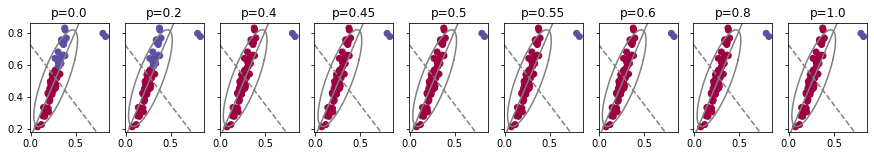

In [139]:
ex_long_gaussian_plus_outliers.plot_clusters();

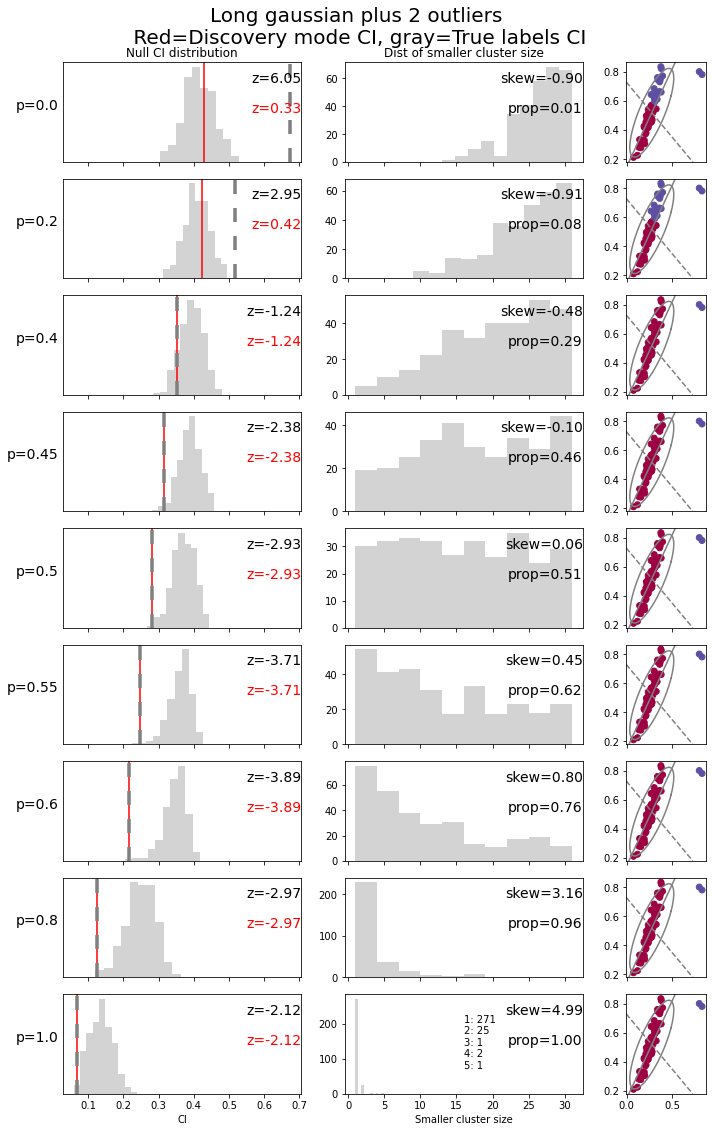

In [140]:
ex_long_gaussian_plus_outliers.plot_scs();

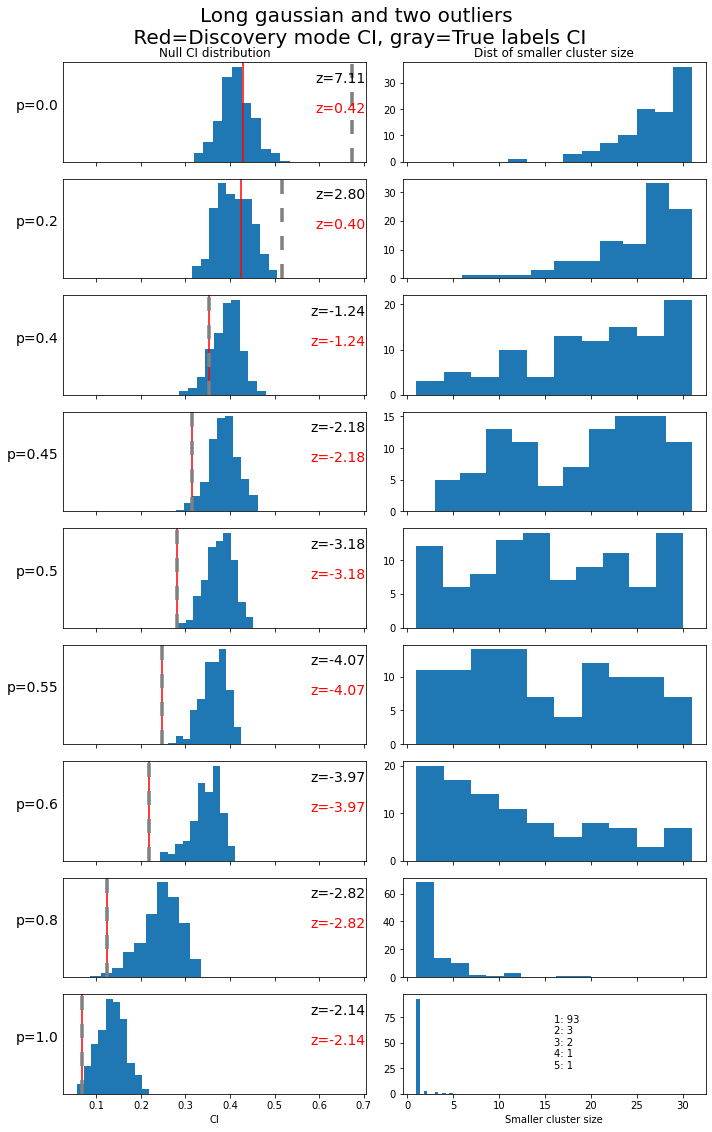

In [80]:
fig, axs = plt.subplots(9, 2, sharex='col', figsize=(10,16))
axs[0,0].set_title("Null CI distribution")
axs[0,1].set_title("Dist of smaller cluster size")
axs[8,0].set_xlabel("CI")
axs[8,1].set_xlabel("Smaller cluster size")
for i in range(9):
    sc = sigclusts[i]
    p = ps[i]
    ax = axs[i, 0]
    ax.hist(sc.simulated_cluster_indices)
    ax.axvline(sc.sample_cluster_index, color='red')
    ax.set_ylabel(f"p={p}", rotation=0, ha='right', fontsize=14)
    ax.get_yaxis().set_ticks([])
    ax.text(1, 0.5, f"z={sc.z_score:.2f}", ha='right', fontsize=14, color='red', transform=ax.transAxes)
    
    true_class1, true_class2 = sigclust.split_data(stretched_gaussian_plus_outliers[['x1','x2']], stretched_gaussian_plus_outliers['label'])
    true_stat = sigclust.compute_average_cluster_index_p_exp(true_class1, true_class2, p)
    true_z = (true_stat - sc.simulated_cluster_indices.mean()) / sc.simulated_cluster_indices.std(ddof=1)
    
    ax.axvline(true_stat, color='gray', linestyle=loosedash, linewidth=3.5)
    ax.text(1, 0.8, f"z={true_z:.2f}", ha='right', color='black', fontsize=14, transform=ax.transAxes)
    
    axs[i,1].hist(balances[i])
    
axs[8,1].text(.5, .8, value_counts(balances[8]), va='top', transform=axs[8,1].transAxes)
    
fig.suptitle("Long gaussian and two outliers\n Red=Discovery mode CI, gray=True labels CI", fontsize=20)
fig.tight_layout()

### Two spherical clusters

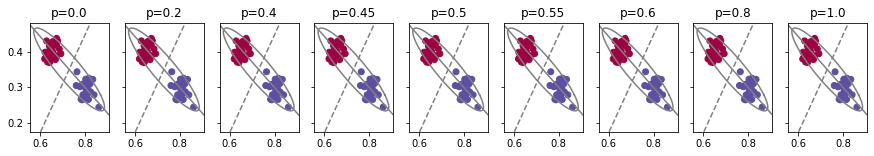

In [129]:
ex_sphericals = Example("Two round clusters", 300)
ex_sphericals.fit(sphericals[['x1','x2']], sphericals['label'])
ex_sphericals.plot_clusters();

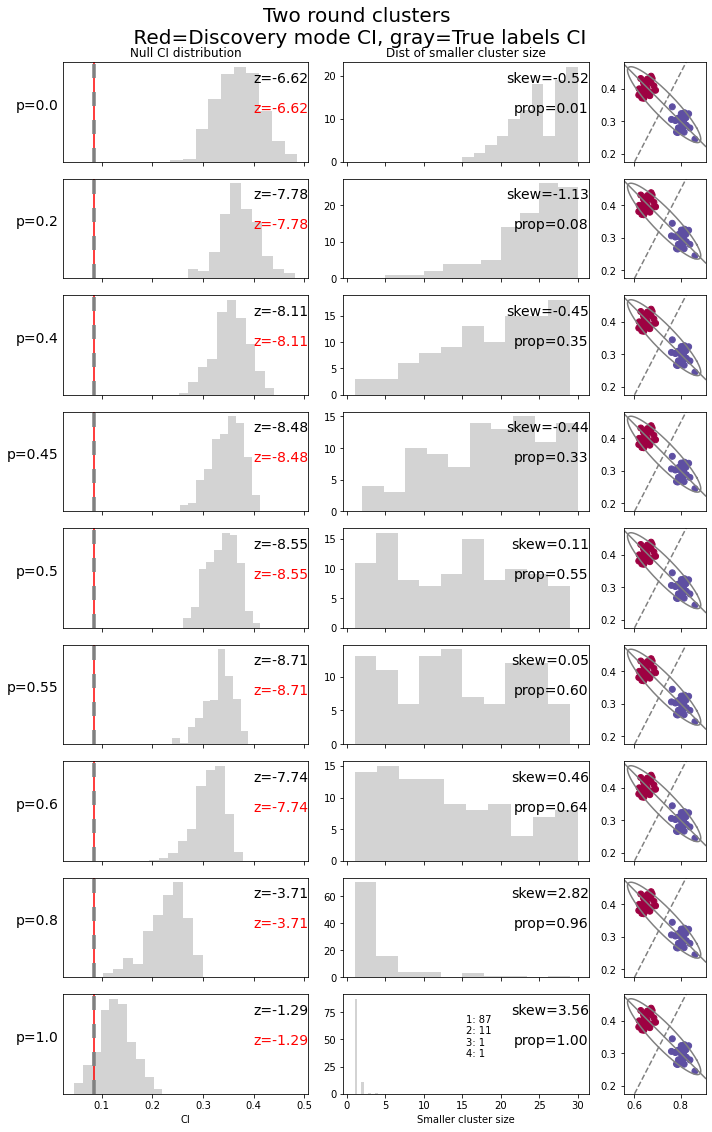

In [130]:
ex_sphericals.plot_scs();

In [81]:
sigclusts = []
for p in ps:
    sc = sigclust.sigclust.AvgCISigClust(num_simulations=300)
    sc.fit(sphericals[['x1','x2']], sphericals['label'], p=p)
    sigclusts.append(sc)

In [82]:
clusterers = [sigclust.Avg2Means() for p in ps]
for p, c in zip(ps, clusterers):
    c.fit(sphericals[['x1','x2']].values, p)

In [83]:
balances = [simulate_balances(sphericals[['x1','x2']], p) for p in ps]

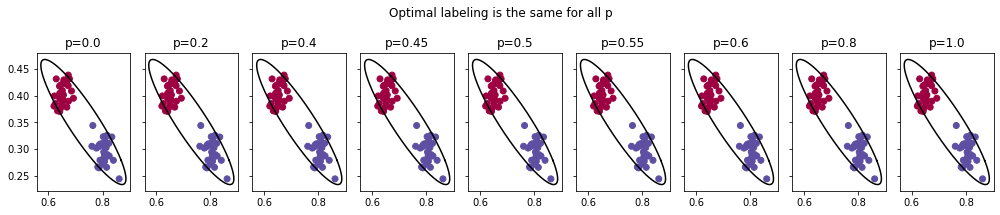

In [84]:
fig, axs = plt.subplots(1, len(ps), figsize=(14,3), sharey=True)
for ax, p, c, in zip(axs, ps, clusterers):
    ax.set_title(f"p={p}")
    labels = c.labels
    ax.scatter(sphericals['x1'], sphericals['x2'], c=labels, cmap='Spectral')
    plot_ellipse(sphericals[['x1','x2']], ax, color='black')
fig.suptitle("Optimal labeling is the same for all p")
fig.tight_layout()

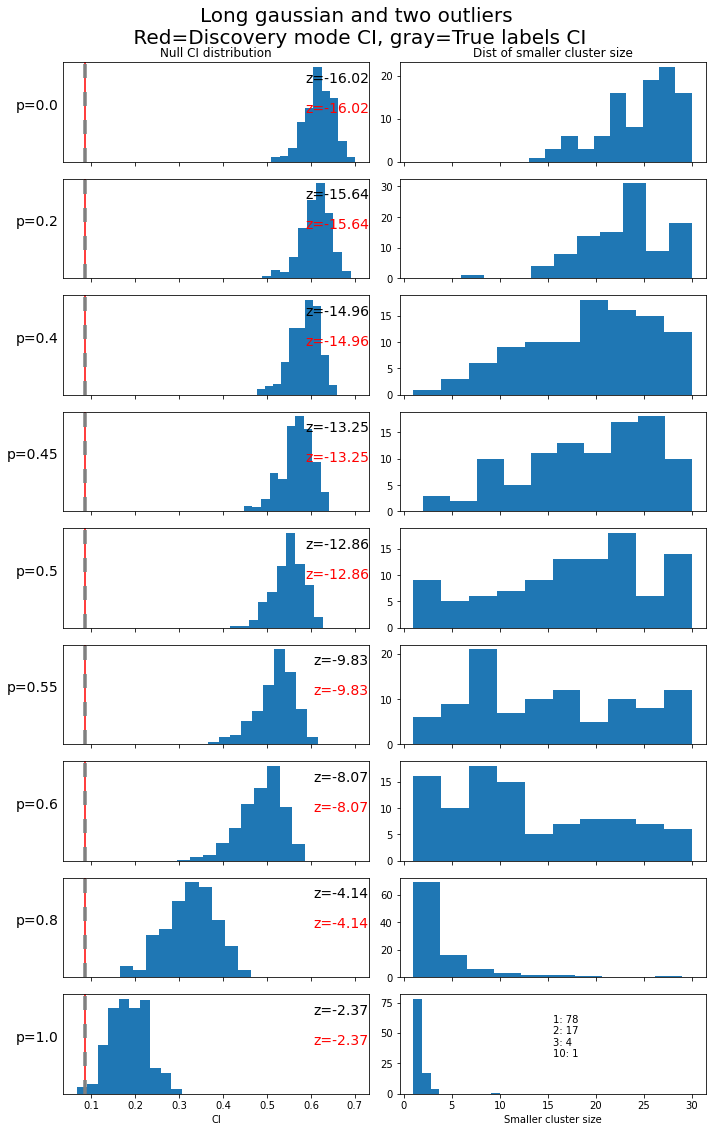

In [85]:
fig, axs = plt.subplots(9, 2, sharex='col', figsize=(10,16))
axs[0,0].set_title("Null CI distribution")
axs[0,1].set_title("Dist of smaller cluster size")
axs[8,0].set_xlabel("CI")
axs[8,1].set_xlabel("Smaller cluster size")
for i in range(9):
    sc = sigclusts[i]
    p = ps[i]
    ax = axs[i, 0]
    ax.hist(sc.simulated_cluster_indices)
    ax.axvline(sc.sample_cluster_index, color='red')
    ax.set_ylabel(f"p={p}", rotation=0, ha='right', fontsize=14)
    ax.get_yaxis().set_ticks([])
    ax.text(1, 0.5, f"z={sc.z_score:.2f}", ha='right', fontsize=14, color='red', transform=ax.transAxes)
    
    true_class1, true_class2 = sigclust.split_data(sphericals[['x1','x2']], sphericals['label'])
    true_stat = sigclust.compute_average_cluster_index_p_exp(true_class1, true_class2, p)
    true_z = (true_stat - sc.simulated_cluster_indices.mean()) / sc.simulated_cluster_indices.std(ddof=1)
    
    ax.axvline(true_stat, color='gray', linestyle=loosedash, linewidth=3.5)
    ax.text(1, 0.8, f"z={true_z:.2f}", ha='right', color='black', fontsize=14, transform=ax.transAxes)
    
    axs[i,1].hist(balances[i])
    
axs[8,1].text(.5, .8, value_counts(balances[8]), va='top', transform=axs[8,1].transAxes)
    
fig.suptitle("Long gaussian and two outliers\n Red=Discovery mode CI, gray=True labels CI", fontsize=20)
fig.tight_layout()

### Long cluster and round cluster

In [118]:
long_cluster_and_round_cluster = toy[toy['label'].isin([1,2])]

In [134]:
ex_long_cluster_and_round_cluster = Example("Long cluster and round cluster", 300)
ex_long_cluster_and_round_cluster.fit(long_cluster_and_round_cluster[['x1','x2']], long_cluster_and_round_cluster['label']);

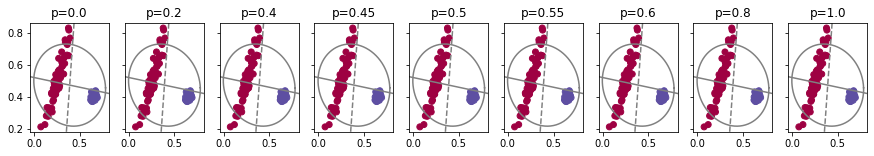

In [135]:
ex_long_cluster_and_round_cluster.plot_clusters();

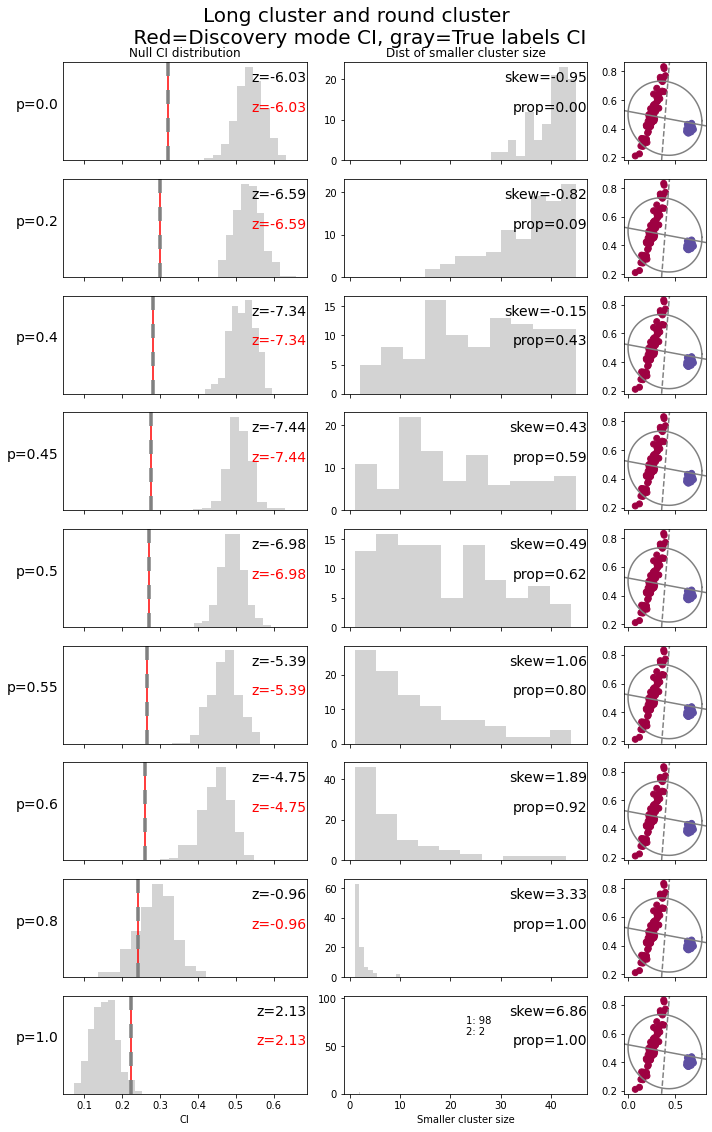

In [136]:
ex_long_cluster_and_round_cluster.plot_scs();

In [87]:
clusterers = [sigclust.Avg2Means() for p in ps]
for c in clusterers:
    c.fit(long_cluster_and_round_cluster[['x1','x2']].values, p)

In [88]:
pc1 = PCA().fit(long_cluster_and_round_cluster[['x1','x2']])
pc1_dir = pc1.components_[0, :]

Text(0.5, 0.98, 'Optimal labeling is the same for all p. Black line is PC1')

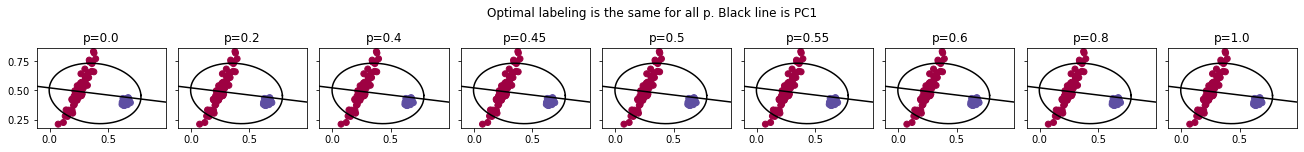

In [120]:
fig, axs = plt.subplots(1, len(ps), figsize=(9*2,2), sharey=True, constrained_layout=True)
for ax, p, c, in zip(axs, ps, clusterers):
    ax.set_title(f"p={p}")
    ax.axis('equal')
    labels = c.labels
    ax.axline(pc1.mean_, pc1.mean_ + .5*pc1_dir, color='black')
    ax.scatter(long_cluster_and_round_cluster['x1'], long_cluster_and_round_cluster['x2'], c=labels, cmap='Spectral')
    plot_ellipse(long_cluster_and_round_cluster[['x1','x2']], ax, color='black')
    
fig.suptitle("Optimal labeling is the same for all p. Black line is PC1")

In [127]:
sigclusts = []
for p, c in zip(ps, clusterers):
    sc = sigclust.AvgCISigClust(num_simulations=100, covariance_method='sample_covariance')
    sc.fit(long_cluster_and_round_cluster[['x1','x2']].values, c.labels, p=p)
    sigclusts.append(sc)

In [128]:
balances = [simulate_balances(long_cluster_and_round_cluster[['x1','x2']], p) for p in ps]

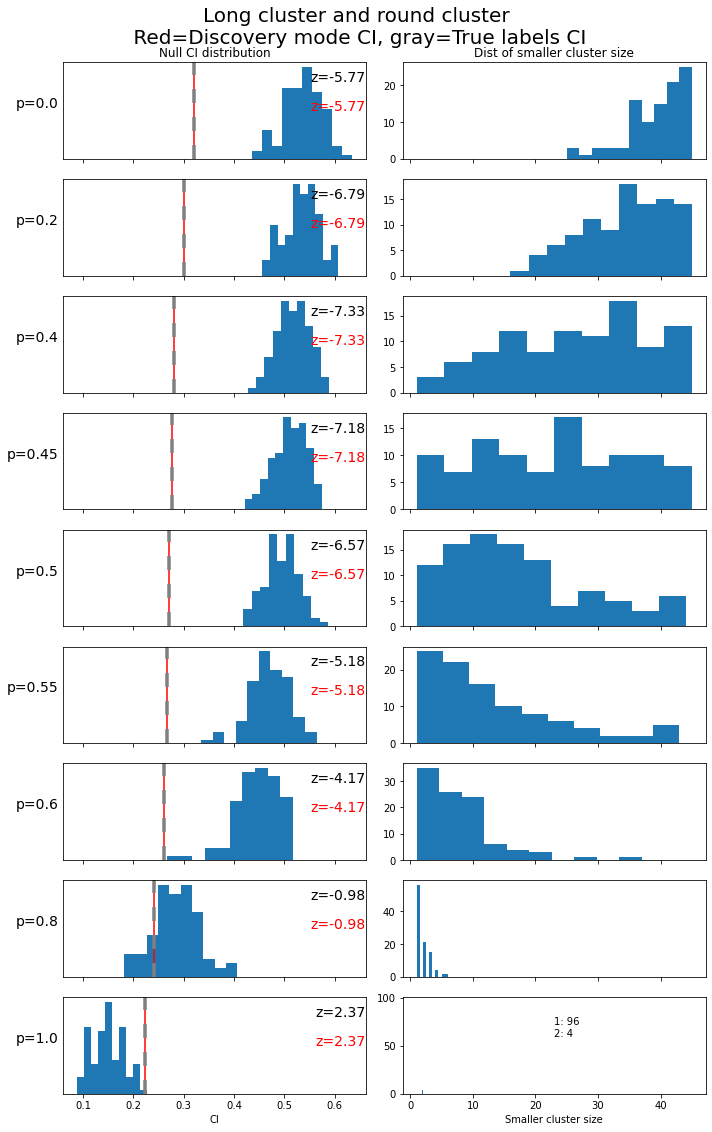

In [129]:
fig, axs = plt.subplots(9, 2, sharex='col', figsize=(10,16))
axs[0,0].set_title("Null CI distribution")
axs[0,1].set_title("Dist of smaller cluster size")
axs[8,0].set_xlabel("CI")
axs[8,1].set_xlabel("Smaller cluster size")
for i in range(9):
    sc = sigclusts[i]
    p = ps[i]
    ax = axs[i, 0]
    ax.hist(sc.simulated_cluster_indices)
    ax.axvline(sc.sample_cluster_index, color='red')
    ax.set_ylabel(f"p={p}", rotation=0, ha='right', fontsize=14)
    ax.get_yaxis().set_ticks([])
    ax.text(1, 0.5, f"z={sc.z_score:.2f}", ha='right', fontsize=14, color='red', transform=ax.transAxes)
    
    true_class1, true_class2 = sigclust.split_data(long_cluster_and_round_cluster[['x1','x2']], long_cluster_and_round_cluster['label'])
    true_stat = sigclust.compute_average_cluster_index_p_exp(true_class1, true_class2, p)
    true_z = (true_stat - sc.simulated_cluster_indices.mean()) / sc.simulated_cluster_indices.std(ddof=1)
    
    ax.axvline(true_stat, color='gray', linestyle=loosedash, linewidth=3.5)
    ax.text(1, 0.8, f"z={true_z:.2f}", ha='right', color='black', fontsize=14, transform=ax.transAxes)
    
    axs[i,1].hist(balances[i])
    
axs[8,1].text(.5, .8, value_counts(balances[8]), va='top', transform=axs[8,1].transAxes)
    
fig.suptitle("Long cluster and round cluster\n Red=Discovery mode CI, gray=True labels CI", fontsize=20)
fig.tight_layout()

For all values of $p$ we know that the optimal labeling is the same, but we see that $p$ affects the sample CI (red line) because the classes are unbalanced (60/30). While I liked the idea of $p=0.8$ because it makes the curve pretty flat (i.e. minimizes the L1 norm of the derivative), using 0.8 is an unacceptable loss of power, while p=0.6 retains the power. 

#### Why $p=1$ can give a test statistic on the wrong side of the histogram:
Note: we could really dig in and figure it out, but it's not worth the time right now.

Now we look at why p=1 gives a sample CI on the wrong side of the histogram

We know the Avg CI (p=1) pulls off one point, which means the Avg CI simplifies to:
$$\begin{aligned}
Avg CI &= \frac{\frac{1}{|C_1|}\sum_{x \in C_1} ||x- \bar{x}_1||^2 + \frac{1}{|C_2|}\sum_{x \in C_2} ||x- \bar{x}_2||^2}{\frac{1}{|C_1|}\sum_{x \in C_1} ||x- \bar{x}||^2 + \frac{1}{|C_2|}\sum_{x \in C_2} ||x- \bar{x}||^2} \\ \\
&= \frac{\frac{1}{|n-1|}\sum_{x \in C_1} ||x- \bar{x}_1||^2}{\frac{1}{|n-1|}\sum_{x \in C_1} ||x- \bar{x}||^2 +\frac{1}{1}\sum_{x \in C_2} ||x- \bar{x}||^2} 
\end{aligned}$$
To understand why sample CI is on the wrong side of the line, we look at an example.

In [257]:
evals = sigclust.get_eigenvalues(long_cluster_and_round_cluster[['x1','x2']], 'sample_covariance')
nulldata = np.random.standard_normal((90,2)) * np.sqrt(evals)

In [258]:
clusterer = sigclust.Avg2Means()
clusterer.fit(nulldata, p=1)

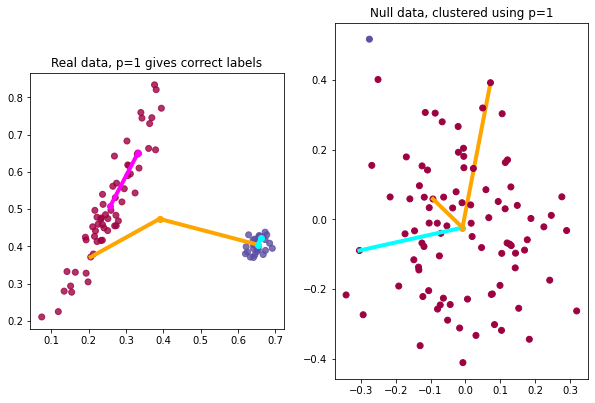

In [263]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title("Real data, p=1 gives correct labels")
plt.scatter(long_cluster_and_round_cluster['x1'], long_cluster_and_round_cluster['x2'], c=clusterers[5].labels.astype(int), cmap='Spectral', alpha=.8)
plt.scatter(long_cluster_and_round_cluster['x1'].mean(), long_cluster_and_round_cluster['x2'].mean(), color='orange')
plt.plot((long_cluster['x1'].mean(), long_cluster.loc[35, 'x1']), (long_cluster['x2'].mean(), long_cluster.loc[35, 'x2']), 'o-', color='magenta', linewidth=4)
plt.plot((long_cluster_and_round_cluster['x1'].mean(), long_cluster.loc[6, 'x1']), (long_cluster_and_round_cluster['x2'].mean(), long_cluster.loc[6, 'x2']), color='orange', linewidth=4)
plt.plot((long_cluster_and_round_cluster['x1'].mean(), round_cluster['x1'].mean()), (long_cluster_and_round_cluster['x2'].mean(), round_cluster['x2'].mean()), color='orange', linewidth=4)
plt.plot((round_cluster.iloc[2, 1], round_cluster['x1'].mean()), (round_cluster.iloc[2, 2], round_cluster['x2'].mean()), 'o-', color='cyan', linewidth=4)



plt.gca().set_aspect('equal')
plt.subplot(122)
plt.title("Null data, clustered using p=1")
plucked_idx = np.where(clusterer.labels==1)[0][0]
plt.plot((nulldata[:, 0].mean(), nulldata[plucked_idx, 0]), (nulldata[:, 1].mean(), nulldata[plucked_idx, 1]), color='orange', linewidth=4, zorder=0)
plt.scatter(nulldata[:, 0], nulldata[:, 1], c=clusterer.labels.astype(int), cmap='Spectral')
plt.scatter(nulldata[:, 0].mean(), nulldata[:, 1].mean(), color='orange')
plt.plot((nulldata[:, 0].mean(), nulldata[24, 0]), (nulldata[:, 1].mean(), nulldata[24, 1]), color='cyan', linewidth=4)
plt.plot((nulldata[:, 0].mean(), nulldata[78, 0]), (nulldata[:, 1].mean(), nulldata[78, 1]), color='orange', linewidth=4)


plt.gca().set_aspect('equal')

In [111]:
long_cluster = toy[toy['label']==1]
long_cluster_sq_dists_to_cluster_mean = (long_cluster - long_cluster.mean(0)).apply(norm, axis=1)**2
long_cluster_sq_dists_to_data_mean = (long_cluster - long_cluster_and_round_cluster.mean(0)).apply(norm, 1)**2

In [112]:
np.abs(long_cluster_sq_dists_to_cluster_mean - long_cluster_sq_dists_to_cluster_mean.mean()).nsmallest(1)

35    0.000311
dtype: float64

In [113]:
np.abs(long_cluster_sq_dists_to_data_mean - long_cluster_sq_dists_to_data_mean.mean()).nsmallest(1)

6    0.000082
dtype: float64

In [123]:
nulldata_sq_dists_to_mean = norm((nulldata - nulldata.mean(0)), axis=1)**2
np.abs(pd.Series(nulldata_sq_dists_to_mean-nulldata_sq_dists_to_mean.mean())).nsmallest(2)

24    0.001290
78    0.001686
dtype: float64

In [262]:
round_cluster = toy[toy['label']==2]

#### We move the circular cluster toward the long cluster

In [132]:
long_cluster_and_round_cluster2 = long_cluster_and_round_cluster.copy()
long_cluster_and_round_cluster2.loc[long_cluster_and_round_cluster2['label']==2, ['x1','x2']] -= (.15*pc1_dir)

pc1_2 = PCA().fit(long_cluster_and_round_cluster2[['x1','x2']])

In [133]:
long_cluster_and_round_cluster3 = long_cluster_and_round_cluster.copy()
long_cluster_and_round_cluster3.loc[long_cluster_and_round_cluster3['label']==2, ['x1','x2']] -= (.3*pc1_dir)

pc1_3 = PCA().fit(long_cluster_and_round_cluster3[['x1','x2']])

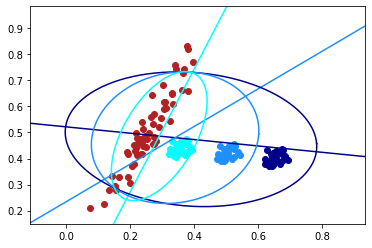

In [148]:
reds, navies = sigclust.split_data(long_cluster_and_round_cluster[['x1','x2']], long_cluster_and_round_cluster['label'])
reds, royals = sigclust.split_data(long_cluster_and_round_cluster2[['x1','x2']], long_cluster_and_round_cluster2['label'])
reds, cyans = sigclust.split_data(long_cluster_and_round_cluster3[['x1','x2']], long_cluster_and_round_cluster3['label'])

plt.scatter(reds['x1'], reds['x2'], color='firebrick')
plt.scatter(navies['x1'], navies['x2'], color='darkblue')
plt.scatter(royals['x1'], royals['x2'], color='dodgerblue')
plt.scatter(cyans['x1'], cyans['x2'], color='aqua')

plt.axline(pc1.mean_, pc1.mean_ + .5*pc1_dir, color='darkblue')
plt.axline(pc1_2.mean_, pc1_2.mean_ + .5*pc1_2.components_[0,:], color='dodgerblue')
plt.axline(pc1_3.mean_, pc1_3.mean_ + .5*pc1_3.components_[0,:], color='aqua')
plot_ellipse(long_cluster_and_round_cluster[['x1','x2']], plt.gca(), color='darkblue')
plot_ellipse(long_cluster_and_round_cluster2[['x1','x2']], plt.gca(), color='dodgerblue')
plot_ellipse(long_cluster_and_round_cluster3[['x1','x2']], plt.gca(), color='aqua')

Now let's do the avg 2 means clustering

In [149]:
clusterers = []
dsets = [long_cluster_and_round_cluster, long_cluster_and_round_cluster2, long_cluster_and_round_cluster3]
pcas = [pc1, pc1_2, pc1_3]

for dset in dsets:
    dset_clusterers = []
    for p in ps:
        clusterer = sigclust.avg_2means.Avg2Means(max_components=2)
        clusterer.fit(dset[['x1','x2']], p=p)
        dset_clusterers.append(clusterer)
    clusterers.append(dset_clusterers)

Text(0, 0.5, 'Near')

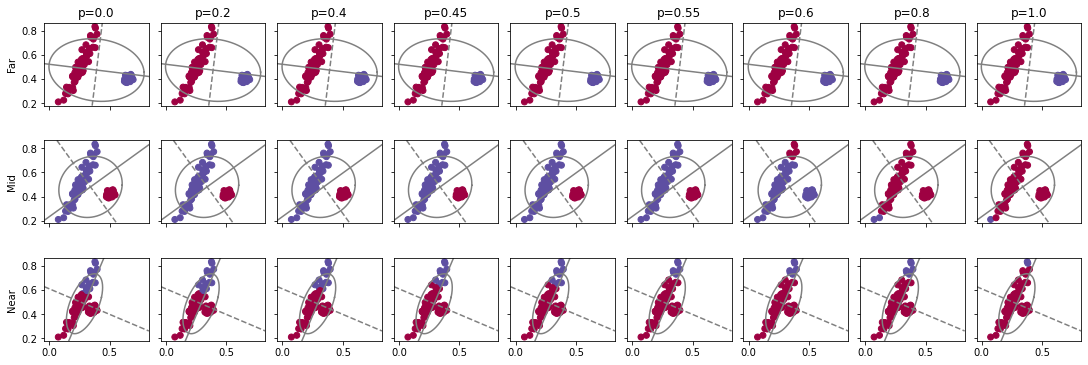

In [166]:
fig, axs = plt.subplots(3, len(ps), figsize=(15,5), sharex='col', sharey='row', subplot_kw={'aspect':1},
                        constrained_layout=True)
for i, (dset, dset_clusterers, pca) in enumerate(zip(dsets, clusterers, pcas)):
    for j, (p, clusterer) in enumerate(zip(ps, dset_clusterers)):
        ax = axs[i,j]
        if i==0:
            ax.set_title(f"p={p}")
        ax.scatter(dset['x1'], dset['x2'], c=clusterer.labels, cmap='Spectral')
        ax.axline(pca.mean_, pca.mean_ + .2*pca.components_[0,:], c='gray')
        ax.axline(pca.mean_, pca.mean_ + .2*pca.components_[1,:], c='gray', linestyle='dashed')
        plot_ellipse(dset[['x1','x2']], ax, color='gray')

axs[0,0].set_ylabel("Far")
axs[1,0].set_ylabel("Mid")
axs[2,0].set_ylabel("Near")

We see that for the near distances, no exponent recovers the correct clustering, even when the method is allowed to search for splits both on PC1 and PC2. This suggests that the theoretical minimizing labeling, i.e. over all subsets, not just ones defines by splits on PCs, is not the correct one.

Fitting a normal mixture model should capture this, though. But we're not in the business of trying to beat low-dimensional normal mixture fitting.

#### Mid distance

In [167]:
sigclusts = []
for i, p in enumerate(ps):
    labels = clusterers[1][i].labels
    sc = sigclust.sigclust.AvgCISigClust(num_simulations=100, covariance_method='sample_covariance', max_components=2)
    sc.fit(long_cluster_and_round_cluster2[['x1','x2']].values, labels, p=p)
    sigclusts.append(sc)

In [168]:
balances = [simulate_balances(long_cluster_and_round_cluster2[['x1','x2']], p) for p in ps]

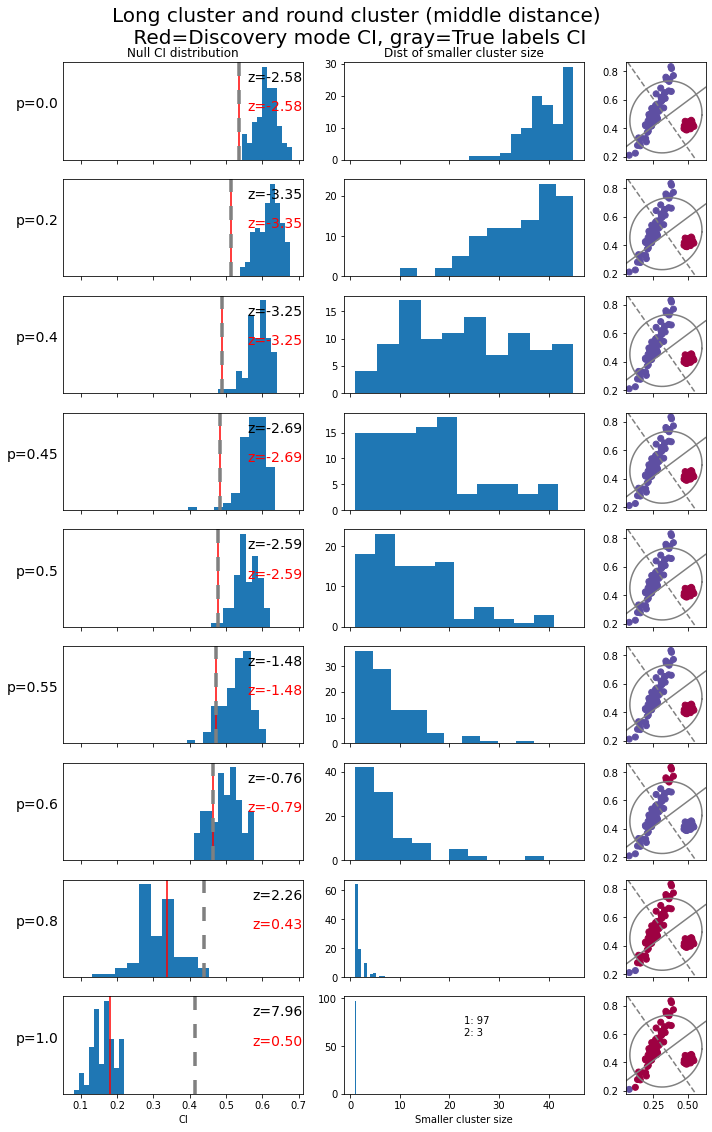

In [174]:
fig, axs = plt.subplots(9, 3, sharex='col', figsize=(10,16), gridspec_kw={'width_ratios': [3, 3, 1]})
axs[0,0].set_title("Null CI distribution")
axs[0,1].set_title("Dist of smaller cluster size")
axs[8,0].set_xlabel("CI")
axs[8,1].set_xlabel("Smaller cluster size")
for i in range(9):
    sc = sigclusts[i]
    p = ps[i]
    ax = axs[i, 0]
    ax.hist(sc.simulated_cluster_indices)
    ax.axvline(sc.sample_cluster_index, color='red')
    ax.set_ylabel(f"p={p}", rotation=0, ha='right', fontsize=14)
    ax.get_yaxis().set_ticks([])
    ax.text(1, 0.5, f"z={sc.z_score:.2f}", ha='right', fontsize=14, color='red', transform=ax.transAxes)
    
    dset = dsets[1]
    true_class1, true_class2 = sigclust.split_data(dset[['x1','x2']], dset['label'])
    true_stat = sigclust.compute_average_cluster_index_p_exp(true_class1, true_class2, p)
    true_z = (true_stat - sc.simulated_cluster_indices.mean()) / sc.simulated_cluster_indices.std(ddof=1)
    
    ax.axvline(true_stat, color='gray', linestyle=loosedash, linewidth=3.5)
    ax.text(1, 0.8, f"z={true_z:.2f}", ha='right', color='black', fontsize=14, transform=ax.transAxes)
    
    axs[i,1].hist(balances[i])
    pca = pcas[1]
    
    scatter_ax = axs[i, 2]
    scatter_ax.scatter(dset['x1'], dset['x2'], c=clusterers[1][i].labels, cmap='Spectral')
    scatter_ax.axline(pca.mean_, pca.mean_ + .2*pca.components_[0,:], c='gray')
    scatter_ax.axline(pca.mean_, pca.mean_ + .2*pca.components_[1,:], c='gray', linestyle='dashed')
    plot_ellipse(dset[['x1','x2']], scatter_ax, color='gray')
    
axs[8,1].text(.5, .8, value_counts(balances[8]), va='top', transform=axs[8,1].transAxes)
    
fig.suptitle("Long cluster and round cluster (middle distance)\n Red=Discovery mode CI, gray=True labels CI", fontsize=20)
fig.tight_layout()

#### Short distance (intutively should split on PC2, but it doesn't)

In [175]:
sigclusts = []
for i, p in enumerate(ps):
    labels = clusterers[2][i].labels
    sc = sigclust.sigclust.AvgCISigClust(num_simulations=100, covariance_method='sample_covariance', max_components=2)
    sc.fit(long_cluster_and_round_cluster3[['x1','x2']].values, labels, p=p)
    sigclusts.append(sc)

In [176]:
balances = [simulate_balances(long_cluster_and_round_cluster3[['x1','x2']], p) for p in ps]

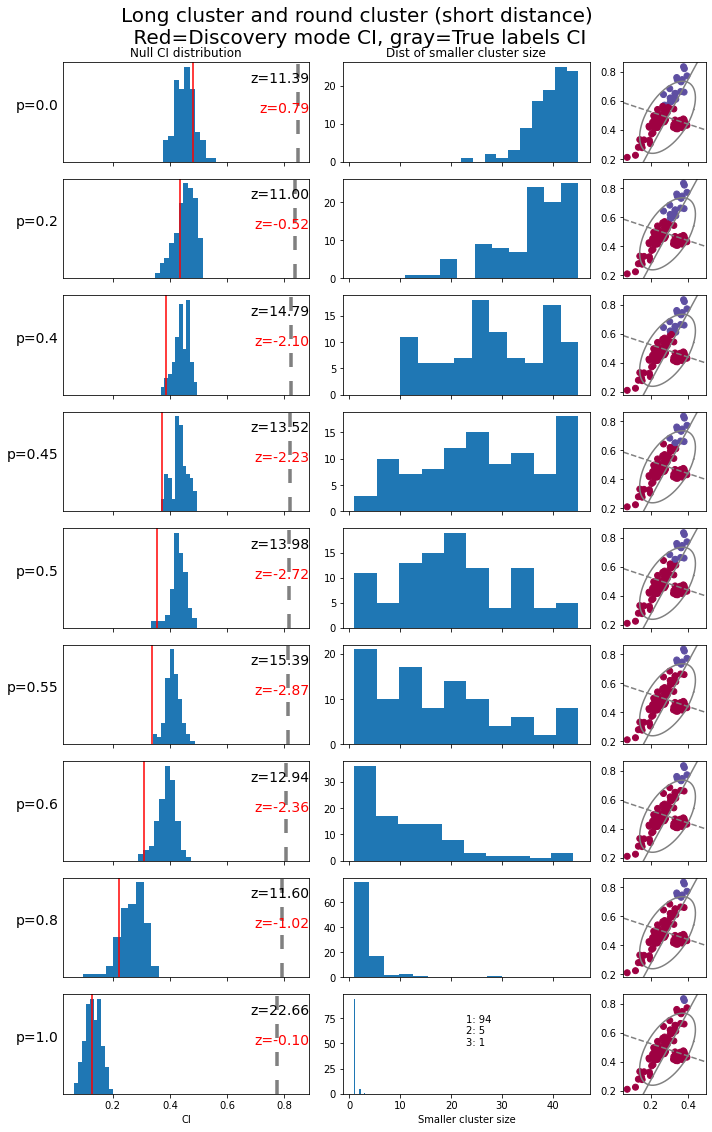

In [177]:
fig, axs = plt.subplots(9, 3, sharex='col', figsize=(10,16), gridspec_kw={'width_ratios': [3, 3, 1]})
axs[0,0].set_title("Null CI distribution")
axs[0,1].set_title("Dist of smaller cluster size")
axs[8,0].set_xlabel("CI")
axs[8,1].set_xlabel("Smaller cluster size")
for i in range(9):
    sc = sigclusts[i]
    p = ps[i]
    ax = axs[i, 0]
    ax.hist(sc.simulated_cluster_indices)
    ax.axvline(sc.sample_cluster_index, color='red')
    ax.set_ylabel(f"p={p}", rotation=0, ha='right', fontsize=14)
    ax.get_yaxis().set_ticks([])
    ax.text(1, 0.5, f"z={sc.z_score:.2f}", ha='right', fontsize=14, color='red', transform=ax.transAxes)
    
    dset = dsets[2]
    true_class1, true_class2 = sigclust.split_data(dset[['x1','x2']], dset['label'])
    true_stat = sigclust.compute_average_cluster_index_p_exp(true_class1, true_class2, p)
    true_z = (true_stat - sc.simulated_cluster_indices.mean()) / sc.simulated_cluster_indices.std(ddof=1)
    
    ax.axvline(true_stat, color='gray', linestyle=loosedash, linewidth=3.5)
    ax.text(1, 0.8, f"z={true_z:.2f}", ha='right', color='black', fontsize=14, transform=ax.transAxes)
    
    axs[i,1].hist(balances[i])
    pca = pcas[2]
    
    scatter_ax = axs[i, 2]
    scatter_ax.scatter(dset['x1'], dset['x2'], c=clusterers[2][i].labels, cmap='Spectral')
    scatter_ax.axline(pca.mean_, pca.mean_ + .2*pca.components_[0,:], c='gray')
    scatter_ax.axline(pca.mean_, pca.mean_ + .2*pca.components_[1,:], c='gray', linestyle='dashed')
    plot_ellipse(dset[['x1','x2']], scatter_ax, color='gray')
    
axs[8,1].text(.5, .8, value_counts(balances[8]), va='top', transform=axs[8,1].transAxes)
    
fig.suptitle("Long cluster and round cluster (short distance)\n Red=Discovery mode CI, gray=True labels CI", fontsize=20)
fig.tight_layout()

## Putting the small cluster right on top of the long cluster
We care about this example because it shows that SigClust is very powerful in this regime--but the test statistic goes the opposite way from when there are well separated clusters.

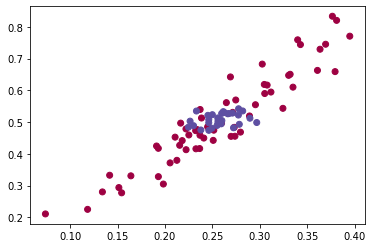

In [184]:
displacement = reds.mean() - navies.mean()
long_cluster_and_round_cluster4 = long_cluster_and_round_cluster.copy()
long_cluster_and_round_cluster4.loc[long_cluster_and_round_cluster4['label']==2.0, ['x1','x2']] += displacement
plt.scatter(long_cluster_and_round_cluster4['x1'], long_cluster_and_round_cluster4['x2'], c=long_cluster_and_round_cluster4['label'], cmap='Spectral')

In [185]:
clusterers = [sigclust.Avg2Means() for p in ps]
for p, c in zip(ps, clusterers):
    c.fit(long_cluster_and_round_cluster4[['x1','x2']], p=p)

In [186]:
sigclusts = []
for c, p in zip(clusterers, ps):
    sc = sigclust.sigclust.AvgCISigClust(num_simulations=100, covariance_method='sample_covariance', max_components=2)
    sc.fit(long_cluster_and_round_cluster4[['x1','x2']].values, c.labels, p=p)
    sigclusts.append(sc)

In [187]:
balances = [simulate_balances(long_cluster_and_round_cluster4[['x1','x2']], p) for p in ps]

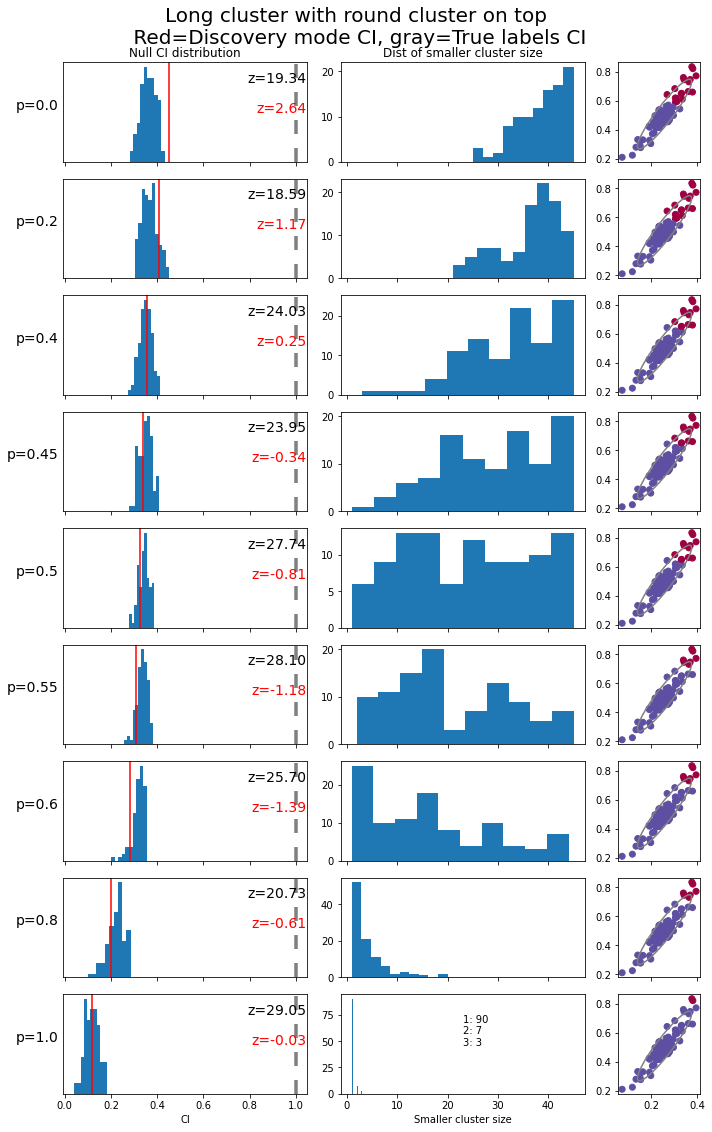

In [189]:
fig, axs = plt.subplots(9, 3, sharex='col', figsize=(10,16), gridspec_kw={'width_ratios': [3, 3, 1]})
axs[0,0].set_title("Null CI distribution")
axs[0,1].set_title("Dist of smaller cluster size")
axs[8,0].set_xlabel("CI")
axs[8,1].set_xlabel("Smaller cluster size")
for i in range(9):
    sc = sigclusts[i]
    p = ps[i]
    ax = axs[i, 0]
    ax.hist(sc.simulated_cluster_indices)
    ax.axvline(sc.sample_cluster_index, color='red')
    ax.set_ylabel(f"p={p}", rotation=0, ha='right', fontsize=14)
    ax.get_yaxis().set_ticks([])
    ax.text(1, 0.5, f"z={sc.z_score:.2f}", ha='right', fontsize=14, color='red', transform=ax.transAxes)
    
    dset = long_cluster_and_round_cluster4
    true_class1, true_class2 = sigclust.split_data(dset[['x1','x2']], dset['label'])
    true_stat = sigclust.compute_average_cluster_index_p_exp(true_class1, true_class2, p)
    true_z = (true_stat - sc.simulated_cluster_indices.mean()) / sc.simulated_cluster_indices.std(ddof=1)
    
    ax.axvline(true_stat, color='gray', linestyle=loosedash, linewidth=3.5)
    ax.text(1, 0.8, f"z={true_z:.2f}", ha='right', color='black', fontsize=14, transform=ax.transAxes)
    
    axs[i,1].hist(balances[i])
    # pca = pcas[2]
    
    scatter_ax = axs[i, 2]
    scatter_ax.scatter(dset['x1'], dset['x2'], c=clusterers[i].labels, cmap='Spectral')
    # scatter_ax.axline(pca.mean_, pca.mean_ + .2*pca.components_[0,:], c='gray')
    # scatter_ax.axline(pca.mean_, pca.mean_ + .2*pca.components_[1,:], c='gray', linestyle='dashed')
    plot_ellipse(dset[['x1','x2']], scatter_ax, color='gray')
    
axs[8,1].text(.5, .8, value_counts(balances[8]), va='top', transform=axs[8,1].transAxes)
    
fig.suptitle("Long cluster with round cluster on top\n Red=Discovery mode CI, gray=True labels CI", fontsize=20)
fig.tight_layout()

Note, the gray statistic *must* be 1 (for all $p$) because the means are exactly on top of each other. 

### One round cluster and two outliers

In [190]:
round_plus_outliers = toy[toy['label'].isin([2,4])]

In [191]:
clusterers = [sigclust.Avg2Means() for p in ps]
for p, c in zip(ps, clusterers):
    c.fit(round_plus_outliers[['x1','x2']].values, p)

In [192]:
balances = [simulate_balances(round_plus_outliers[['x1','x2']], p) for p in ps]

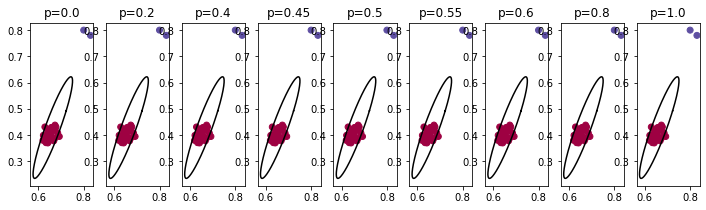

In [198]:
fig, axs = plt.subplots(1,len(ps), figsize=(12,3))
for ax, p, c in zip(axs, ps, clusterers):
    ax.set_title(f"p={p}")
    ax.scatter(round_plus_outliers['x1'], round_plus_outliers['x2'], c=c.labels, cmap='Spectral')
    plot_ellipse(round_plus_outliers[['x1','x2']], ax, color='black')

In [199]:
sigclusts = []
for p, c in zip(ps, clusterers):
    sc = sigclust.sigclust.AvgCISigClust(num_simulations=100, covariance_method='sample_covariance')
    sc.fit(round_plus_outliers[['x1','x2']].values, c.labels, p=p)
    sigclusts.append(sc)

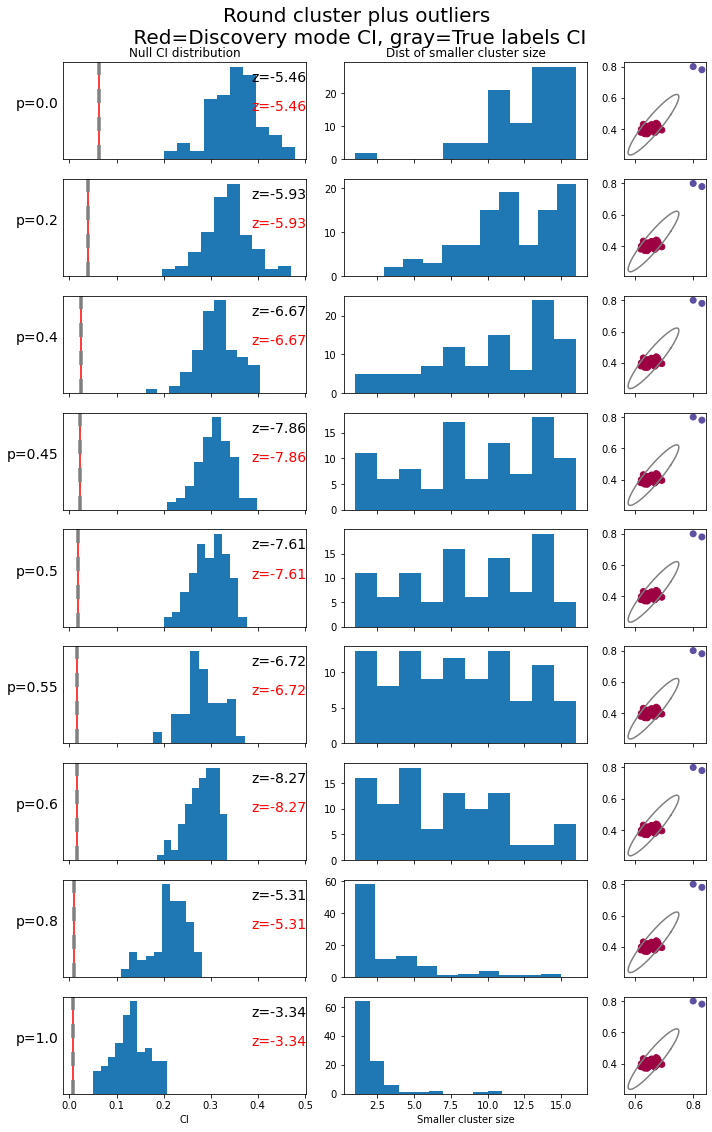

In [201]:
fig, axs = plt.subplots(9, 3, sharex='col', figsize=(10,16), gridspec_kw={'width_ratios': [3, 3, 1]})
axs[0,0].set_title("Null CI distribution")
axs[0,1].set_title("Dist of smaller cluster size")
axs[8,0].set_xlabel("CI")
axs[8,1].set_xlabel("Smaller cluster size")
for i in range(9):
    sc = sigclusts[i]
    p = ps[i]
    ax = axs[i, 0]
    ax.hist(sc.simulated_cluster_indices)
    ax.axvline(sc.sample_cluster_index, color='red')
    ax.set_ylabel(f"p={p}", rotation=0, ha='right', fontsize=14)
    ax.get_yaxis().set_ticks([])
    ax.text(1, 0.5, f"z={sc.z_score:.2f}", ha='right', fontsize=14, color='red', transform=ax.transAxes)
    
    dset = round_plus_outliers
    true_class1, true_class2 = sigclust.split_data(dset[['x1','x2']], dset['label'])
    true_stat = sigclust.compute_average_cluster_index_p_exp(true_class1, true_class2, p)
    true_z = (true_stat - sc.simulated_cluster_indices.mean()) / sc.simulated_cluster_indices.std(ddof=1)
    
    ax.axvline(true_stat, color='gray', linestyle=loosedash, linewidth=3.5)
    ax.text(1, 0.8, f"z={true_z:.2f}", ha='right', color='black', fontsize=14, transform=ax.transAxes)
    
    axs[i,1].hist(balances[i])
    # pca = pcas[2]
    
    scatter_ax = axs[i, 2]
    scatter_ax.scatter(dset['x1'], dset['x2'], c=clusterers[i].labels, cmap='Spectral')
    # scatter_ax.axline(pca.mean_, pca.mean_ + .2*pca.components_[0,:], c='gray')
    # scatter_ax.axline(pca.mean_, pca.mean_ + .2*pca.components_[1,:], c='gray', linestyle='dashed')
    plot_ellipse(dset[['x1','x2']], scatter_ax, color='gray')
    
# axs[8,1].text(.5, .8, value_counts(balances[8]), va='top', transform=axs[8,1].transAxes)
    
fig.suptitle("Round cluster plus outliers\n Red=Discovery mode CI, gray=True labels CI", fontsize=20)
fig.tight_layout()

### Stretched gaussian alone (Null)

In [212]:
hotdog = toy[toy['label']==1][['x1','x2']]

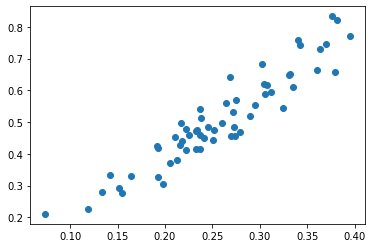

In [213]:
plt.scatter(hotdog['x1'], hotdog['x2'])

In [214]:
clusterers = [sigclust.avg_2means.Avg2Means() for p in ps]
for p, c in zip(ps, clusterers):
    c.fit(hotdog, p)

In [215]:
balances = [simulate_balances(hotdog[['x1','x2']], p) for p in ps]

In [216]:
sigclusts = []
for p, c in zip(ps, clusterers):
    sc = sigclust.sigclust.AvgCISigClust(covariance_method='sample_covariance', num_simulations=200)
    sc.fit(hotdog.values, c.labels, p=p)
    sigclusts.append(sc)

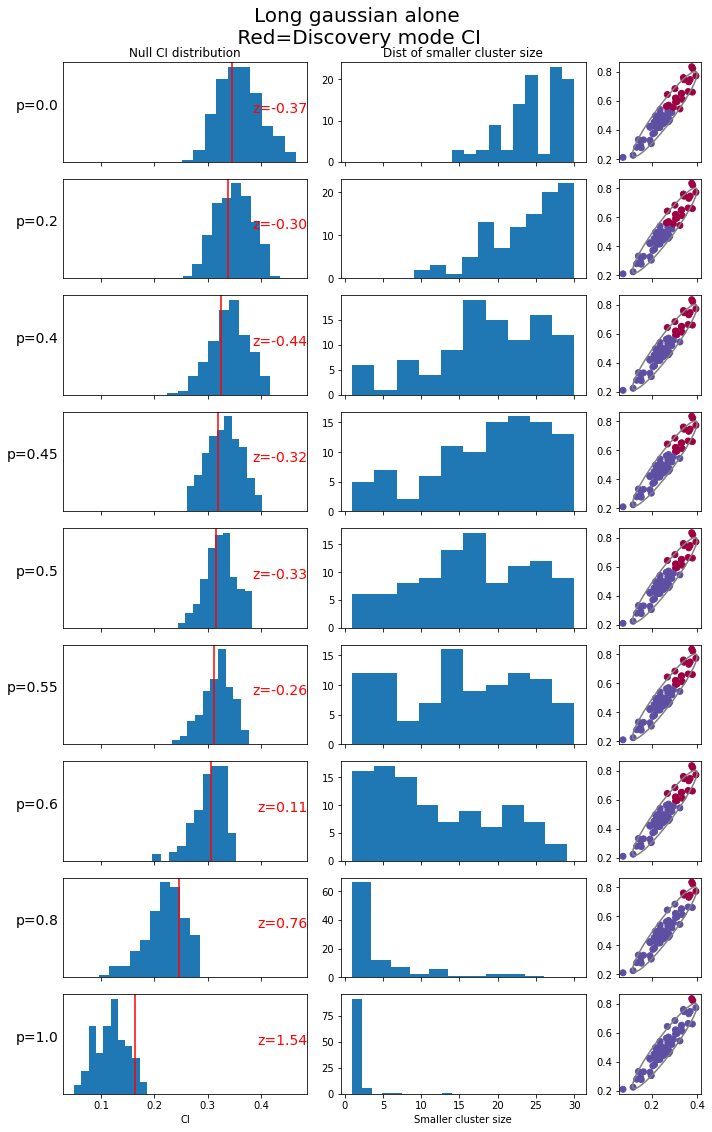

In [217]:
fig, axs = plt.subplots(9, 3, sharex='col', figsize=(10,16), gridspec_kw={'width_ratios': [3, 3, 1]})
axs[0,0].set_title("Null CI distribution")
axs[0,1].set_title("Dist of smaller cluster size")
axs[8,0].set_xlabel("CI")
axs[8,1].set_xlabel("Smaller cluster size")
for i in range(9):
    sc = sigclusts[i]
    p = ps[i]
    ax = axs[i, 0]
    ax.hist(sc.simulated_cluster_indices)
    ax.axvline(sc.sample_cluster_index, color='red')
    ax.set_ylabel(f"p={p}", rotation=0, ha='right', fontsize=14)
    ax.get_yaxis().set_ticks([])
    ax.text(1, 0.5, f"z={sc.z_score:.2f}", ha='right', fontsize=14, color='red', transform=ax.transAxes)
    
    dset = hotdog
    
    axs[i,1].hist(balances[i])
    # pca = pcas[2]
    
    scatter_ax = axs[i, 2]
    scatter_ax.scatter(dset['x1'], dset['x2'], c=clusterers[i].labels, cmap='Spectral')
    # scatter_ax.axline(pca.mean_, pca.mean_ + .2*pca.components_[0,:], c='gray')
    # scatter_ax.axline(pca.mean_, pca.mean_ + .2*pca.components_[1,:], c='gray', linestyle='dashed')
    plot_ellipse(dset[['x1','x2']], scatter_ax, color='gray')
    
# axs[8,1].text(.5, .8, value_counts(balances[8]), va='top', transform=axs[8,1].transAxes)
    
fig.suptitle("Long gaussian alone\n Red=Discovery mode CI", fontsize=20)
fig.tight_layout()

Maybe here, add a gray bar (or another color) showing the resulting statistic for the labeling that splits the data at the midpoint of PC1 (i.e. using PC2 as the splitting plane)

### Round cluster (Null)

In [218]:
round_cluster = toy[toy['label']==2][['x1','x2']]

In [219]:
clusterers = [sigclust.avg_2means.Avg2Means(max_components=2) for p in ps]
for p, c in zip(ps, clusterers):
    c.fit(round_cluster.values, p)

In [220]:
balances = [simulate_balances(round_cluster[['x1','x2']], p) for p in ps]

In [221]:
sigclusts = []
for p, c in zip(ps, clusterers):
    sc = sigclust.sigclust.AvgCISigClust(covariance_method='sample_covariance', num_simulations=200, max_components=2)
    sc.fit(round_cluster.values, c.labels, p=p)
    sigclusts.append(sc)

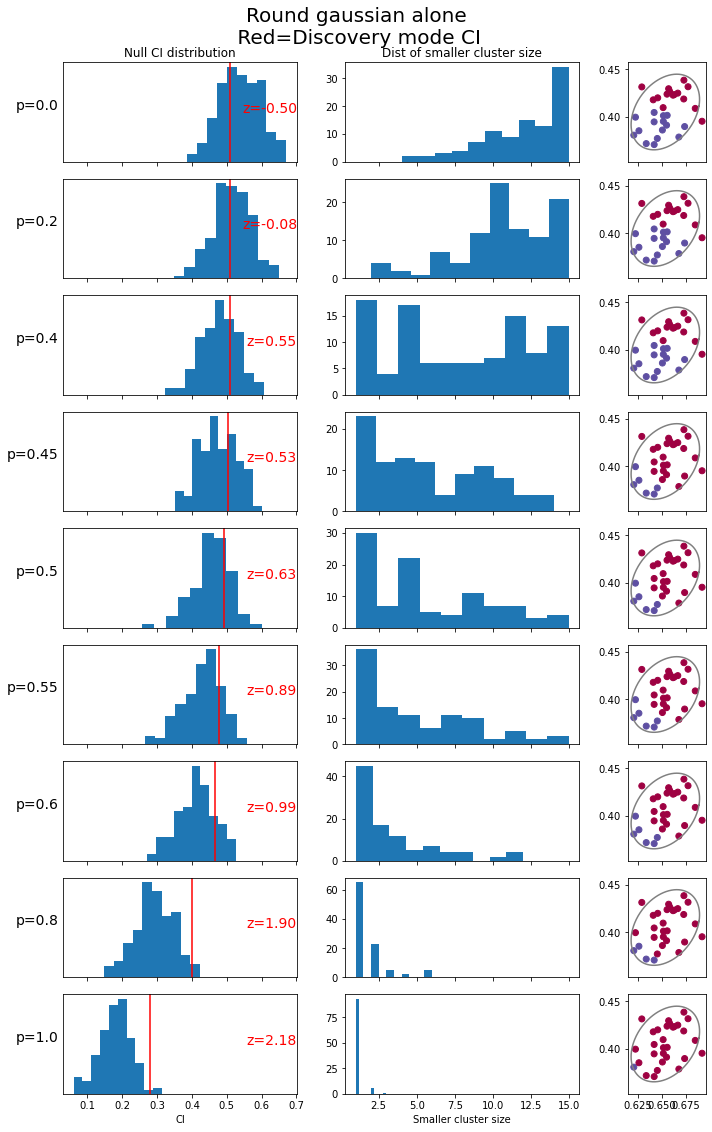

In [225]:
fig, axs = plt.subplots(9, 3, sharex='col', figsize=(10,16), gridspec_kw={'width_ratios': [3, 3, 1]})
axs[0,0].set_title("Null CI distribution")
axs[0,1].set_title("Dist of smaller cluster size")
axs[8,0].set_xlabel("CI")
axs[8,1].set_xlabel("Smaller cluster size")
for i in range(9):
    sc = sigclusts[i]
    p = ps[i]
    ax = axs[i, 0]
    ax.hist(sc.simulated_cluster_indices)
    ax.axvline(sc.sample_cluster_index, color='red')
    ax.set_ylabel(f"p={p}", rotation=0, ha='right', fontsize=14)
    ax.get_yaxis().set_ticks([])
    ax.text(1, 0.5, f"z={sc.z_score:.2f}", ha='right', fontsize=14, color='red', transform=ax.transAxes)
    
    dset = round_cluster
    
    axs[i,1].hist(balances[i])
    # pca = pcas[2]
    
    scatter_ax = axs[i, 2]
    scatter_ax.scatter(dset['x1'], dset['x2'], c=clusterers[i].labels, cmap='Spectral')
    # scatter_ax.axline(pca.mean_, pca.mean_ + .2*pca.components_[0,:], c='gray')
    # scatter_ax.axline(pca.mean_, pca.mean_ + .2*pca.components_[1,:], c='gray', linestyle='dashed')
    plot_ellipse(dset[['x1','x2']], scatter_ax, color='gray')
    scatter_ax.axis('equal')
    
# axs[8,1].text(.5, .8, value_counts(balances[8]), va='top', transform=axs[8,1].transAxes)
    
fig.suptitle("Round gaussian alone\n Red=Discovery mode CI", fontsize=20)
fig.tight_layout()

Maybe this is feeling the estimation. The true difference in eigenvalues is 0, but the sample estimate will have a positive difference.

In [123]:
from tqdm import tqdm

In [157]:
z_scores = np.zeros((6, 100))
est_eigen_ratios = np.zeros((6, 100))

with tqdm(total=6*100) as progressbar:
    for i in range(6):
        p = i/5

        for j in range(100):
            mat = np.random.standard_normal((30,2))
            clusterer = sigclust.avg_2means.Avg2Means(max_components=2)
            clusterer.fit(mat, p=p)

            sc = sigclust.AvgCISigClust(covariance_method='sample_covariance', max_components=2, num_simulations=100)
            sc.fit(mat, clusterer.labels, p=p)

            z_scores[i,j] = sc.z_score
            evals = sigclust.get_eigenvalues(mat, covariance_method='sample_covariance')
            est_eigen_ratios[i,j] = evals[0]/evals[1]
            progressbar.update(1)
    
    
    
    

100%|██████████| 600/600 [06:17<00:00,  1.59it/s]


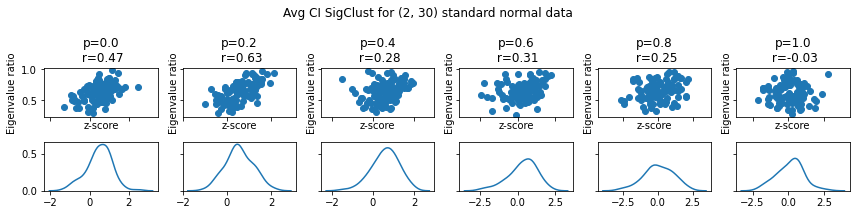

In [158]:
fig, axs = plt.subplots(2, 6, figsize=(12,3), sharex='col', sharey='row')
for i in range(6):
    axs[0,i].scatter(z_scores[i,:], est_eigen_ratios[i,:])
    r = scipy.stats.pearsonr(z_scores[i,:], est_eigen_ratios[i,:])[0]
    axs[0,i].set_title(f"p={i/5}\n r={r:.2f}")
    axs[0,i].set_xlabel("z-score")
    axs[0,i].set_ylabel("Eigenvalue ratio")
    sns.kdeplot(z_scores[i,:], ax=axs[1,i])
    
fig.suptitle("Avg CI SigClust for (2, 30) standard normal data")
fig.tight_layout()
    

### Some thoughts:
Suppose someone has truly Gaussian data, and they use SigClust in discovery mode with $p=0.8$. That will give them a sample CI and a null distribution. What is the size of the test? I.e. What is the probability that the red line is below the .05 quantile of null distribution when the data is truly Gaussian? It seems like it's lower than .05, which means the empirical p-value _is a p-value_ but very conservative. 



(Point from Dr. Marron) Say someone simulates data from N(0,1) and then looks as $\bar{x}$ and $s$. Depending on which one is unusually big, they decide to either do a mean test or an SD test. We do this simulation over and over again, each time letting them choose which test to use. Think of the person as applying an overall test where the first step is looking at $\bar{x}$ and $s$ and choosing which test to use. This overall test is the geared to reject even when it shouldn't, i.e. it's anti-conservative.

Similarly, we run into the same issue if we let people use different values of $p$.

### The minimizing gaussian deviate as a function of $p$, and the minimizing quantile as a function of $p$
For example, if we wanted to use the value of $p$ that would naturally split at the $z_{.98}$ quantile, what would we use?

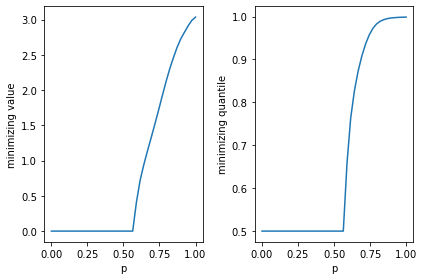

In [59]:
fig, axs = plt.subplots(1,2)

minimizers = resultsZ[resultsZ.index >= 0].idxmin()

minimizers.plot(kind='line', ax=axs[0])
axs[0].set_xlabel('p')
axs[0].set_ylabel('minimizing value')

axs[1].plot(minimizers.index, scipy.stats.norm.cdf(minimizers))
axs[1].set_xlabel('p')
axs[1].set_ylabel('minimizing quantile')

fig.tight_layout()

Construct example where p=.75 gives the most power:
try using a round cluster of 75 and another of 25, and see if by moving them closer and farther apart if we can get p=.75 gives most power. Would be best if values below .59 were not actually significant.